In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot
from math import sqrt
import scipy as sp
from scipy import stats
import scipy.signal
from scipy.signal import fftconvolve, convolve
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact

from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import *

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV, LogisticRegression
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer, ENGLISH_STOP_WORDS
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn import datasets
from textblob import TextBlob, Word
from nltk.stem.snowball import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords

from gensim import corpora, models, matutils
from collections import defaultdict

import statsmodels.api as sm
import statsmodels.formula.api as sm
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

import patsy
from itertools import combinations

import json

%matplotlib inline
#plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Data Science - Parts Demand Case Study

Scenario:
A part demand planner’s core responsibility is to get parts by working with various suppliers.
A part demand planner comes to you with a list of historical parts used in repairs. He wants your support with a few things –
 
1. To help him understand the data – what trend do you see?
2. To help predict next year’s parts demand (forecast at part level and weekly level).
3. To build a systematic solution to help predict thousands of other parts which he can share the data with you depending on how you support his needs in this round.
 
· What questions would you have for him? <br>
· Based on available data, and you can make assumptions as needed, provide the results in an easy-to-understand way. <br>

### Reading a File

In [2]:
# Create data path variable for loading data
data_path = '/Users/yangweichle/Documents/Employment/JOB APPLICATIONS/BAY AREA/DATA SCIENTIST/!Tesla_Data Scientist/'

In [3]:
# Read file into DataFrame
# Note: skiprows=1 skips the first row
case_study = pd.read_csv(data_path + 'Case Study_a.csv', skiprows=1) # Comma-separated values file

### Examine the DataFrame

In [4]:
# Return the number of rows and columns (dimensionality) of the DataFrame
print('Rows: {}, Cols: {}'.format(case_study.shape[0], case_study.shape[1]))

Rows: 26, Cols: 108


In [5]:
# Print a concise summary of a DataFrame including the index dtype and column dtypes, non-null values, and memory usage
# Note: Useful to quickly see if null values exist 
case_study.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 108 columns):
Part #   \ Week number    int64
19                        float64
20                        float64
21                        float64
22                        float64
23                        float64
24                        float64
25                        float64
26                        float64
27                        float64
28                        float64
29                        float64
30                        float64
31                        float64
32                        float64
33                        float64
34                        float64
35                        float64
36                        float64
37                        float64
38                        float64
39                        float64
40                        float64
41                        float64
42                        float64
43                        float64
44            

In [6]:
# Print the first 5 rows and the last 5 rows of the DataFrame
case_study.head().append(case_study.tail())

,Part # \ Week number,19,20,21,22,23,24,25,26,27,...,10.1,11.1,12.1,13.1,14.1,15.1,16.1,17.1,18.1,19.2
0,1,NaN,576.0,490.0,615.0,583.0,609.0,528.0,535.0,575.0,...,1387.0,1290.0,1394.0,1346.0,1416.0,1261.0,1321.0,1371.0,1345.0,1337.0
1,2,NaN,561.0,476.0,604.0,580.0,613.0,541.0,541.0,581.0,...,1437.0,1317.0,1397.0,1353.0,1449.0,1304.0,1321.0,1390.0,1368.0,1377.0
2,3,NaN,547.0,478.0,579.0,565.0,583.0,565.0,540.0,550.0,...,1297.0,1164.0,1239.0,1182.0,1201.0,1154.0,1121.0,1172.0,1148.0,1127.0
3,4,NaN,559.0,489.0,593.0,594.0,596.0,561.0,532.0,550.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,NaN,8.0,5.0,8.0,6.0,10.0,5.0,3.0,2.0,...,1689.0,1507.0,1646.0,1574.0,1632.0,1554.0,1545.0,1570.0,1508.0,1560.0
21,22,2.0,447.0,391.0,429.0,418.0,393.0,421.0,377.0,357.0,...,37.0,19.0,21.0,22.0,21.0,11.0,23.0,23.0,20.0,25.0
22,23,NaN,110.0,74.0,92.0,83.0,97.0,79.0,72.0,97.0,...,198.0,169.0,185.0,215.0,263.0,242.0,267.0,233.0,232.0,239.0
23,24,NaN,55.0,54.0,77.0,63.0,63.0,65.0,77.0,62.0,...,235.0,205.0,209.0,198.0,199.0,199.0,207.0,198.0,231.0,189.0
24,25,NaN,61.0,55.0,61.0,65.0,63.0,71.0,60.0,68.0,...,235.0,225.0,231.0,257.0,213.0,205.0,218.0,220.0,221.0,180.0
25,26,2.0,431.0,383.0,408.0,406.0,380.0,406.0,367.0,346.0,...,33.0,18.0,20.0,22.0,20.0,10.0,21.0,22.0,19.0,22.0


In [7]:
# Rename one or more columns in the original DataFrame rather than returning a new view
# Note: inplace=True changes the original DataFrame
case_study.rename(columns={'Part #   \ Week number': 'part_num'}, inplace=True)

In [8]:
case_study

,part_num,19,20,21,22,23,24,25,26,27,...,10.1,11.1,12.1,13.1,14.1,15.1,16.1,17.1,18.1,19.2
0,1,NaN,576.0,490.0,615.0,583.0,609.0,528.0,535.0,575.0,...,1387.0,1290.0,1394.0,1346.0,1416.0,1261.0,1321.0,1371.0,1345.0,1337.0
1,2,NaN,561.0,476.0,604.0,580.0,613.0,541.0,541.0,581.0,...,1437.0,1317.0,1397.0,1353.0,1449.0,1304.0,1321.0,1390.0,1368.0,1377.0
2,3,NaN,547.0,478.0,579.0,565.0,583.0,565.0,540.0,550.0,...,1297.0,1164.0,1239.0,1182.0,1201.0,1154.0,1121.0,1172.0,1148.0,1127.0
3,4,NaN,559.0,489.0,593.0,594.0,596.0,561.0,532.0,550.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,NaN,8.0,5.0,8.0,6.0,10.0,5.0,3.0,2.0,...,1689.0,1507.0,1646.0,1574.0,1632.0,1554.0,1545.0,1570.0,1508.0,1560.0
5,6,NaN,217.0,169.0,219.0,203.0,194.0,193.0,224.0,213.0,...,697.0,616.0,678.0,649.0,699.0,660.0,643.0,713.0,698.0,699.0
6,7,NaN,84.0,54.0,83.0,87.0,93.0,103.0,122.0,131.0,...,653.0,554.0,582.0,630.0,673.0,610.0,590.0,624.0,647.0,609.0
7,8,NaN,119.0,85.0,112.0,109.0,99.0,98.0,147.0,159.0,...,581.0,511.0,550.0,548.0,592.0,544.0,542.0,603.0,603.0,588.0
8,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,660.0,600.0,594.0,582.0,658.0,532.0,535.0,598.0,556.0,569.0
9,10,NaN,335.0,214.0,322.0,342.0,361.0,377.0,260.0,140.0,...,1028.0,726.0,796.0,682.0,268.0,193.0,200.0,232.0,236.0,344.0


### Setting up 2015 data

In [9]:
# Use 'iloc' to filter rows and select columns by integer position
# Note: Remember that rows/columns use indices, so iloc lets you refer to indices via their index rather than value!)

# Select all rows, columns in position 0-34
# Note: Here it is NOT INCLUDING 35 because this is an integer range, not a Pandas index range!
year2015 = case_study.iloc[:, :35]

In [10]:
# Creating constant value for year
year2015['year'] = 2015

In [11]:
year2015

,part_num,19,20,21,22,23,24,25,26,27,...,44,45,46,47,48,49,50,51,52,year
0,1,NaN,576.0,490.0,615.0,583.0,609.0,528.0,535.0,575.0,...,770.0,841.0,837.0,698.0,856.0,877.0,869.0,452.0,449.0,2015
1,2,NaN,561.0,476.0,604.0,580.0,613.0,541.0,541.0,581.0,...,777.0,852.0,815.0,668.0,852.0,880.0,871.0,455.0,445.0,2015
2,3,NaN,547.0,478.0,579.0,565.0,583.0,565.0,540.0,550.0,...,742.0,801.0,797.0,648.0,805.0,827.0,822.0,411.0,418.0,2015
3,4,NaN,559.0,489.0,593.0,594.0,596.0,561.0,532.0,550.0,...,822.0,920.0,913.0,772.0,907.0,882.0,936.0,481.0,486.0,2015
4,5,NaN,8.0,5.0,8.0,6.0,10.0,5.0,3.0,2.0,...,6.0,10.0,11.0,9.0,13.0,11.0,10.0,7.0,7.0,2015
5,6,NaN,217.0,169.0,219.0,203.0,194.0,193.0,224.0,213.0,...,308.0,327.0,299.0,230.0,292.0,271.0,268.0,134.0,140.0,2015
6,7,NaN,84.0,54.0,83.0,87.0,93.0,103.0,122.0,131.0,...,236.0,245.0,261.0,200.0,262.0,258.0,236.0,139.0,135.0,2015
7,8,NaN,119.0,85.0,112.0,109.0,99.0,98.0,147.0,159.0,...,212.0,197.0,173.0,140.0,155.0,144.0,111.0,51.0,56.0,2015
8,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,49.0,152.0,187.0,161.0,181.0,209.0,162.0,102.0,58.0,2015
9,10,NaN,335.0,214.0,322.0,342.0,361.0,377.0,260.0,140.0,...,197.0,232.0,270.0,335.0,327.0,307.0,475.0,365.0,258.0,2015


In [12]:
# Print a concise summary of a DataFrame including the index dtype and column dtypes, non-null values, and memory usage
# Note: Useful to quickly see if null values exist 
year2015.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 36 columns):
part_num    26 non-null int64
19          3 non-null float64
20          24 non-null float64
21          24 non-null float64
22          24 non-null float64
23          24 non-null float64
24          24 non-null float64
25          24 non-null float64
26          24 non-null float64
27          24 non-null float64
28          24 non-null float64
29          24 non-null float64
30          24 non-null float64
31          24 non-null float64
32          25 non-null float64
33          24 non-null float64
34          24 non-null float64
35          24 non-null float64
36          24 non-null float64
37          24 non-null float64
38          24 non-null float64
39          24 non-null float64
40          24 non-null float64
41          24 non-null float64
42          25 non-null float64
43          25 non-null float64
44          25 non-null float64
45          25 non-null float64
46  

In [13]:
# Fill NA/NaN values with 0s and then convert column to integer
year2015 = year2015.fillna(0).astype(int)

In [14]:
# "Unpivots" a DataFrame from wide format to long format, optionally leaving identifier variables set
year2015_long = pd.melt(year2015,
                        id_vars=['part_num', 'year'], 
                        value_vars=['19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32',
                                    '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46',
                                    '47', '48', '49', '50', '51', '52'],
                        var_name='week', value_name='part_count')

In [15]:
year2015_long = year2015_long[['year', 'week', 'part_num', 'part_count']]

In [16]:
# Print the first 5 rows and the last 5 rows of the DataFrame
year2015_long.head().append(year2015_long.tail())

,year,week,part_num,part_count
0,2015,19,1,0
1,2015,19,2,0
2,2015,19,3,0
3,2015,19,4,0
4,2015,19,5,0
879,2015,52,22,76
880,2015,52,23,69
881,2015,52,24,123
882,2015,52,25,51
883,2015,52,26,71


### Setting up 2016 data

In [17]:
# Use 'iloc' to filter rows and select columns by integer position
# Note: Remember that rows/columns use indices, so iloc lets you refer to indices via their index rather than value!)

# Select all rows, columns in position 0-34
# Note: Here it is NOT INCLUDING 88 because this is an integer range, not a Pandas index range!
year2016 = case_study.iloc[:, :88]

In [18]:
# Creating constant value for year
year2016['year'] = 2016

In [19]:
# Print a concise summary of a DataFrame including the index dtype and column dtypes, non-null values, and memory usage
# Note: Useful to quickly see if null values exist 
year2016.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 89 columns):
part_num    26 non-null int64
19          3 non-null float64
20          24 non-null float64
21          24 non-null float64
22          24 non-null float64
23          24 non-null float64
24          24 non-null float64
25          24 non-null float64
26          24 non-null float64
27          24 non-null float64
28          24 non-null float64
29          24 non-null float64
30          24 non-null float64
31          24 non-null float64
32          25 non-null float64
33          24 non-null float64
34          24 non-null float64
35          24 non-null float64
36          24 non-null float64
37          24 non-null float64
38          24 non-null float64
39          24 non-null float64
40          24 non-null float64
41          24 non-null float64
42          25 non-null float64
43          25 non-null float64
44          25 non-null float64
45          25 non-null float64
46  

In [20]:
#year2016

In [21]:
# Dropping week columns from 2015

# Remove multiple columns on the original DataFrame rather than returning a new view
# Note: axis=0 for rows, 1 for columns
#       inplace=True changes the original DataFrame
year2016.drop(['19', '20', '21', '22', '23', '24', '25', '26', '27', '28',
               '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40',
               '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52'], axis=1, inplace=True)

In [22]:
# Dropping week 0 because it represents the first week (and possibly a partial week) of the year 
#   and it may contain incomplete data for the week

# Remove multiple columns on the original DataFrame rather than returning a new view
# Note: axis=0 for rows, 1 for columns
#       inplace=True changes the original DataFrame
year2016.drop(['0'], axis=1, inplace=True)

In [23]:
#year2016

In [24]:
# Print a concise summary of a DataFrame including the index dtype and column dtypes, non-null values, and memory usage
# Note: Useful to quickly see if null values exist 
year2016.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 54 columns):
part_num    26 non-null int64
1           25 non-null float64
2           25 non-null float64
3           25 non-null float64
4           25 non-null float64
5           25 non-null float64
6           25 non-null float64
7           25 non-null float64
8           25 non-null float64
9           26 non-null int64
10          26 non-null int64
11          26 non-null int64
12          26 non-null int64
13          26 non-null int64
14          26 non-null int64
15          26 non-null int64
16          26 non-null int64
17          26 non-null int64
18          26 non-null int64
19.1        26 non-null int64
20.1        26 non-null int64
21.1        26 non-null int64
22.1        26 non-null int64
23.1        26 non-null int64
24.1        26 non-null int64
25.1        26 non-null int64
26.1        26 non-null int64
27.1        26 non-null int64
28.1        26 non-null int64
29.1       

In [25]:
# Rename one or more columns in the original DataFrame rather than returning a new view
# Note: inplace=True changes the original DataFrame
year2016.rename(columns={'19.1': '19',
                         '20.1': '20',
                         '21.1': '21',
                         '22.1': '22', 
                         '23.1': '23', 
                         '24.1': '24', 
                         '25.1': '25', 
                         '26.1': '26', 
                         '27.1': '27', 
                         '28.1': '28', 
                         '29.1': '29', 
                         '30.1': '30',
                         '31.1': '31', 
                         '32.1': '32', 
                         '33.1': '33', 
                         '34.1': '34', 
                         '35.1': '35', 
                         '36.1': '36', 
                         '37.1': '37', 
                         '38.1': '38', 
                         '39.1': '39',
                         '40.1': '40', 
                         '41.1': '41', 
                         '42.1': '42', 
                         '43.1': '43', 
                         '44.1': '44', 
                         '45.1': '45', 
                         '46.1': '46', 
                         '47.1': '47', 
                         '48.1': '48',
                         '49.1': '49', 
                         '50.1': '50', 
                         '51.1': '51', 
                         '52.1': '52'}, inplace=True)

In [26]:
# Fill NA/NaN values with 0s and then convert column to integer
year2016 = year2016.fillna(0).astype(int)

In [27]:
year2016.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 54 columns):
part_num    26 non-null int64
1           26 non-null int64
2           26 non-null int64
3           26 non-null int64
4           26 non-null int64
5           26 non-null int64
6           26 non-null int64
7           26 non-null int64
8           26 non-null int64
9           26 non-null int64
10          26 non-null int64
11          26 non-null int64
12          26 non-null int64
13          26 non-null int64
14          26 non-null int64
15          26 non-null int64
16          26 non-null int64
17          26 non-null int64
18          26 non-null int64
19          26 non-null int64
20          26 non-null int64
21          26 non-null int64
22          26 non-null int64
23          26 non-null int64
24          26 non-null int64
25          26 non-null int64
26          26 non-null int64
27          26 non-null int64
28          26 non-null int64
29          26 non-null int

In [28]:
#year2016

In [29]:
# "Unpivots" a DataFrame from wide format to long format, optionally leaving identifier variables set
year2016_long = pd.melt(year2016,
                        id_vars=['part_num', 'year'], 
                        value_vars=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14',
                                    '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27',
                                    '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40',
                                    '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52'], 
                        var_name='week', value_name='part_count')

In [30]:
year2016_long = year2016_long[['year', 'week', 'part_num', 'part_count']]

In [31]:
# Print the first 5 rows and the last 5 rows of the DataFrame
year2016_long.head().append(year2016_long.tail())

,year,week,part_num,part_count
0,2016,1,1,1066
1,2016,1,2,1080
2,2016,1,3,980
3,2016,1,4,1026
4,2016,1,5,9
1347,2016,52,22,11
1348,2016,52,23,142
1349,2016,52,24,166
1350,2016,52,25,104
1351,2016,52,26,9


### Setting up 2017 data

In [32]:
# Use 'iloc' to filter rows and select columns by integer position
# Note: Remember that rows/columns use indices, so iloc lets you refer to indices via their index rather than value!)

# Select all rows, columns
year2017 = case_study.iloc[:, :]

In [33]:
# Creating constant value for year
year2017['year'] = 2017

In [34]:
# Print a concise summary of a DataFrame including the index dtype and column dtypes, non-null values, and memory usage
# Note: Useful to quickly see if null values exist 
year2017.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 109 columns):
part_num    int64
19          float64
20          float64
21          float64
22          float64
23          float64
24          float64
25          float64
26          float64
27          float64
28          float64
29          float64
30          float64
31          float64
32          float64
33          float64
34          float64
35          float64
36          float64
37          float64
38          float64
39          float64
40          float64
41          float64
42          float64
43          float64
44          float64
45          float64
46          float64
47          float64
48          float64
49          float64
50          float64
51          float64
52          float64
0           float64
1           float64
2           float64
3           float64
4           float64
5           float64
6           float64
7           float64
8           float64
9           int64


In [35]:
#year2017

In [36]:
# Dropping week columns from 2015 and 2016

# Remove multiple columns on the original DataFrame rather than returning a new view
# Note: axis=0 for rows, 1 for columns
#       inplace=True changes the original DataFrame
year2017.drop(['19', '20', '21', '22', '23', '24', '25', '26', '27', '28',
               '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40',
               '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52',
               '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', 
               '14', '15', '16', '17', '18', '19.1', '20.1', '21.1', '22.1', '23.1', 
               '24.1', '25.1', '26.1', '27.1', '28.1', '29.1', '30.1', '31.1', '32.1', 
               '33.1', '34.1', '35.1', '36.1', '37.1', '38.1', '39.1', '40.1', '41.1', 
               '42.1', '43.1', '44.1', '45.1', '46.1', '47.1', '48.1', '49.1', '50.1', 
               '51.1', '52.1'], axis=1, inplace=True)

In [37]:
#year2017

In [38]:
# Print a concise summary of a DataFrame including the index dtype and column dtypes, non-null values, and memory usage
# Note: Useful to quickly see if null values exist 
year2017.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 22 columns):
part_num    26 non-null int64
0.1         16 non-null float64
1.1         25 non-null float64
2.1         25 non-null float64
3.1         25 non-null float64
4.1         25 non-null float64
5.1         25 non-null float64
6.1         25 non-null float64
7.1         25 non-null float64
8.1         25 non-null float64
9.1         25 non-null float64
10.1        25 non-null float64
11.1        25 non-null float64
12.1        25 non-null float64
13.1        25 non-null float64
14.1        25 non-null float64
15.1        25 non-null float64
16.1        25 non-null float64
17.1        25 non-null float64
18.1        25 non-null float64
19.2        25 non-null float64
year        26 non-null int64
dtypes: float64(20), int64(2)
memory usage: 4.5 KB


In [39]:
# Rename one or more columns in the original DataFrame rather than returning a new view
# Note: inplace=True changes the original DataFrame
year2017.rename(columns={'0.1': '0',
                         '1.1': '1',
                         '2.1': '2',
                         '3.1': '3',
                         '4.1': '4',
                         '5.1': '5',
                         '6.1': '6',
                         '7.1': '7',
                         '8.1': '8',
                         '9.1': '9',
                         '10.1': '10',
                         '11.1': '11',
                         '12.1': '12', 
                         '13.1': '13', 
                         '14.1': '14', 
                         '15.1': '15', 
                         '16.1': '16', 
                         '17.1': '17', 
                         '18.1': '18', 
                         '19.2': '19'}, inplace=True)

In [40]:
# Dropping week 0 because it represents the first week (and possibly a partial week) of the year 
#   and it may contain incomplete data for the week

# Remove multiple columns on the original DataFrame rather than returning a new view
# Note: axis=0 for rows, 1 for columns
#       inplace=True changes the original DataFrame
year2017.drop(['0'], axis=1, inplace=True)

In [41]:
# Print a concise summary of a DataFrame including the index dtype and column dtypes, non-null values, and memory usage
# Note: Useful to quickly see if null values exist 
year2017.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 21 columns):
part_num    26 non-null int64
1           25 non-null float64
2           25 non-null float64
3           25 non-null float64
4           25 non-null float64
5           25 non-null float64
6           25 non-null float64
7           25 non-null float64
8           25 non-null float64
9           25 non-null float64
10          25 non-null float64
11          25 non-null float64
12          25 non-null float64
13          25 non-null float64
14          25 non-null float64
15          25 non-null float64
16          25 non-null float64
17          25 non-null float64
18          25 non-null float64
19          25 non-null float64
year        26 non-null int64
dtypes: float64(19), int64(2)
memory usage: 4.3 KB


In [42]:
# Fill NA/NaN values with 0s and then convert column to integer
year2017 = year2017.fillna(0).astype(int)

In [43]:
# "Unpivots" a DataFrame from wide format to long format, optionally leaving identifier variables set
year2017_long = pd.melt(year2017,
                        id_vars=['part_num', 'year'],
                        value_vars=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', 
                                    '11', '12', '13', '14', '15', '16', '17', '18', '19'],
                        var_name='week', value_name='part_count')

In [44]:
year2017_long = year2017_long[['year', 'week', 'part_num', 'part_count']]

In [45]:
# Print the first 5 rows and the last 5 rows of the DataFrame
year2017_long.head().append(year2017_long.tail())

,year,week,part_num,part_count
0,2017,1,1,965
1,2017,1,2,974
2,2017,1,3,938
3,2017,1,4,0
4,2017,1,5,962
489,2017,19,22,25
490,2017,19,23,239
491,2017,19,24,189
492,2017,19,25,180
493,2017,19,26,22


### Combining 2015-2017 data

In [46]:
all_years = year2015_long.append(year2016_long).append(year2017_long)

### Examine the DataFrame

In [47]:
# Return the number of rows and columns (dimensionality) of the DataFrame
print('Rows: {}, Cols: {}'.format(all_years.shape[0], all_years.shape[1]))

Rows: 2730, Cols: 4


In [48]:
# Print a concise summary of a DataFrame including the index dtype and column dtypes, non-null values, and memory usage
# Note: Useful to quickly see if null values exist
all_years.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2730 entries, 0 to 493
Data columns (total 4 columns):
year          2730 non-null int64
week          2730 non-null object
part_num      2730 non-null int64
part_count    2730 non-null int64
dtypes: int64(3), object(1)
memory usage: 106.6+ KB


In [49]:
# Convert the data type of a column to a specified data type
all_years['week'] = all_years.week.astype('int')

In [50]:
# Print the first 5 rows and the last 5 rows of the DataFrame
all_years.head().append(all_years.tail())

,year,week,part_num,part_count
0,2015,19,1,0
1,2015,19,2,0
2,2015,19,3,0
3,2015,19,4,0
4,2015,19,5,0
489,2017,19,22,25
490,2017,19,23,239
491,2017,19,24,189
492,2017,19,25,180
493,2017,19,26,22


### Summarize the DataFrame

In [51]:
# Describe numeric columns
# Generates descriptive summary statistics of the central tendency, dispersion, and shape of the distribution
# Note: By default only numeric (int64) fields are returned
#       Excludes "NaN" (missing) values
# Remove multiple columns
# Note: axis=0 for rows, 1 for columns
all_years.drop(['year'], axis=1).describe()

,week,part_num,part_count
count,2730.000000,2730.000000,2730.000000
mean,26.428571,13.500000,315.661905
std,14.957183,7.501374,323.971261
min,1.000000,1.000000,0.000000
25%,14.000000,7.000000,105.000000
50%,26.000000,13.500000,213.000000
75%,39.000000,20.000000,384.750000
max,52.000000,26.000000,1689.000000


#### Overall summary statistics

In [52]:
# For each part_num, describe part_count:
all_years.groupby(by='part_num').part_count.describe()

,count,mean,std,min,25%,50%,75%,max
part_num,,,,,,,,
1,105.0,934.000000,288.551355,0.0,746.0,927.0,1125.0,1467.0
2,105.0,931.504762,293.256586,0.0,744.0,917.0,1101.0,1483.0
3,105.0,901.000000,273.875709,0.0,694.0,938.0,1120.0,1428.0
4,105.0,492.142857,413.955670,0.0,0.0,563.0,896.0,1076.0
5,105.0,468.152381,650.169339,0.0,8.0,19.0,1257.0,1689.0
6,105.0,386.847619,168.366289,0.0,268.0,364.0,508.0,732.0
7,105.0,337.952381,173.917829,0.0,200.0,319.0,473.0,673.0
8,105.0,295.790476,149.893981,0.0,173.0,288.0,389.0,614.0
9,105.0,296.000000,216.812663,0.0,58.0,316.0,476.0,663.0


#### 2015 summary statistics

In [53]:
# For each part_num, describe part_count:
all_years[all_years.year == 2015].groupby(by='part_num').part_count.describe()

,count,mean,std,min,25%,50%,75%,max
part_num,,,,,,,,
1,34.0,623.147059,164.781606,0.0,550.25,580.5,736.25,877.0
2,34.0,620.705882,166.241433,0.0,545.75,580.5,741.00,880.0
3,34.0,593.970588,154.800651,0.0,539.25,565.5,694.25,827.0
4,34.0,648.441176,186.111272,0.0,538.25,595.0,772.75,936.0
5,34.0,6.558824,3.086541,0.0,5.00,7.0,8.00,13.0
6,34.0,214.941176,63.869631,0.0,185.25,217.5,264.50,327.0
7,34.0,155.529412,62.918531,0.0,122.25,146.0,198.25,262.0
8,34.0,142.823529,48.833341,0.0,113.75,147.5,177.50,222.0
9,34.0,37.352941,68.636452,0.0,0.00,0.0,38.50,209.0


#### 2016 summary statistics

In [54]:
# For each part_num, describe part_count:
all_years[all_years.year == 2016].groupby(by='part_num').part_count.describe()

,count,mean,std,min,25%,50%,75%,max
part_num,,,,,,,,
1,52.0,990.307692,142.736084,659.0,892.25,968.5,1080.50,1368.0
2,52.0,980.269231,141.314711,651.0,882.75,953.0,1067.75,1367.0
3,52.0,987.019231,161.620773,615.0,892.75,959.5,1077.00,1341.0
4,52.0,569.769231,462.993441,0.0,0.00,867.0,956.25,1076.0
5,52.0,397.365385,563.707094,7.0,16.50,21.0,1020.25,1489.0
6,52.0,402.134615,85.062844,213.0,350.25,389.0,424.75,601.0
7,52.0,357.711538,87.796855,176.0,296.00,344.5,389.00,587.0
8,52.0,313.653846,81.091545,162.0,272.25,308.5,338.25,474.0
9,52.0,359.846154,108.159901,152.0,301.25,353.5,435.75,596.0


#### 2017 summary statistics

In [55]:
# For each part_num, describe part_count:
all_years[all_years.year == 2017].groupby(by='part_num').part_count.describe()

,count,mean,std,min,25%,50%,75%,max
part_num,,,,,,,,
1,19.0,1336.157895,105.665228,965.0,1309.0,1345.0,1390.5,1467.0
2,19.0,1354.210526,108.177621,974.0,1319.0,1368.0,1414.5,1483.0
3,19.0,1215.000000,109.209788,938.0,1159.0,1197.0,1281.0,1428.0
4,19.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
5,19.0,1487.894737,165.667637,962.0,1418.5,1545.0,1582.0,1689.0
6,19.0,652.631579,68.870418,429.0,621.5,660.0,698.5,732.0
7,19.0,610.315789,58.097669,402.0,600.0,624.0,643.0,673.0
8,19.0,520.631579,91.274440,285.0,488.5,548.0,590.0,614.0
9,19.0,584.105263,63.733730,393.0,556.5,594.0,616.5,663.0


#### Time Series Analysis

In [56]:
# Create datetime variable
all_years['Date'] = pd.to_datetime(all_years.week.astype(str) + all_years.year.astype(str).add('-1'), format='%W%Y-%w')

In [57]:
# Print a concise summary of a DataFrame including the index dtype and column dtypes, non-null values, and memory usage
# Note: Useful to quickly see if null values exist 
all_years.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2730 entries, 0 to 493
Data columns (total 5 columns):
year          2730 non-null int64
week          2730 non-null int64
part_num      2730 non-null int64
part_count    2730 non-null int64
Date          2730 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(4)
memory usage: 128.0 KB


In [58]:
# Set the DataFrame index (row labels) using one or more existing columns; by default yields a new object
# Note: inplace=True changes the original DataFrame
all_years.set_index('Date', inplace=True)

In [59]:
# Print the first 5 rows and the last 5 rows of the DataFrame
all_years.head().append(all_years.tail())

,year,week,part_num,part_count
Date,,,,
2015-05-11,2015,19,1,0
2015-05-11,2015,19,2,0
2015-05-11,2015,19,3,0
2015-05-11,2015,19,4,0
2015-05-11,2015,19,5,0
2017-05-08,2017,19,22,25
2017-05-08,2017,19,23,239
2017-05-08,2017,19,24,189
2017-05-08,2017,19,25,180


In [60]:
# Convenience method for frequency conversion and resampling of time series
# Note: First argument is rule, the offset string or object representing target conversion
#       'D'=calendar day frequency; 'W'=weekly frequency; 'M'=month end frequency;
#       'Q'=quarter end frequency; 'A','Y'=year end frequency
for i in range(1, 27):
    print('Part {}'.format(i))
    print(all_years[all_years.part_num == i][['part_count']].resample('Y').mean())
    print('')

Part 1
             part_count
Date                   
2015-12-31   623.147059
2016-12-31   990.307692
2017-12-31  1336.157895

Part 2
             part_count
Date                   
2015-12-31   620.705882
2016-12-31   980.269231
2017-12-31  1354.210526

Part 3
             part_count
Date                   
2015-12-31   593.970588
2016-12-31   987.019231
2017-12-31  1215.000000

Part 4
            part_count
Date                  
2015-12-31  648.441176
2016-12-31  569.769231
2017-12-31    0.000000

Part 5
             part_count
Date                   
2015-12-31     6.558824
2016-12-31   397.365385
2017-12-31  1487.894737

Part 6
            part_count
Date                  
2015-12-31  214.941176
2016-12-31  402.134615
2017-12-31  652.631579

Part 7
            part_count
Date                  
2015-12-31  155.529412
2016-12-31  357.711538
2017-12-31  610.315789

Part 8
            part_count
Date                  
2015-12-31  142.823529
2016-12-31  313.653846
2017-12-31  520.6315

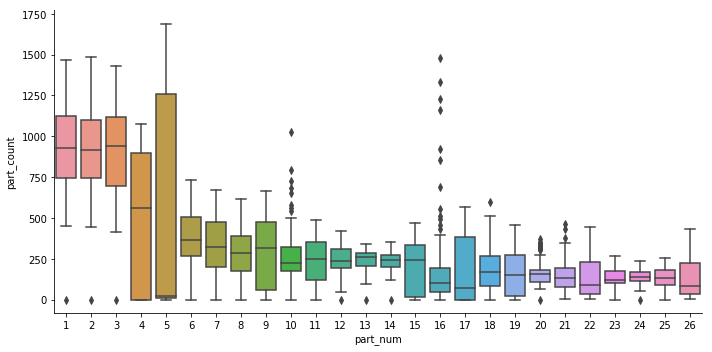

In [61]:
# Draw a categorical plot onto a FacetGrid using Seaborn's .factorplot() function
# Note: kind: the kind of plot to draw
#       size: height (in inches) of each facet
#       aspect: aspect ratio of each facet, so that `aspect*size` gives the width of each facet in inches
sns.factorplot(x='part_num', y='part_count', data=all_years, kind='box', size=5, aspect=2);

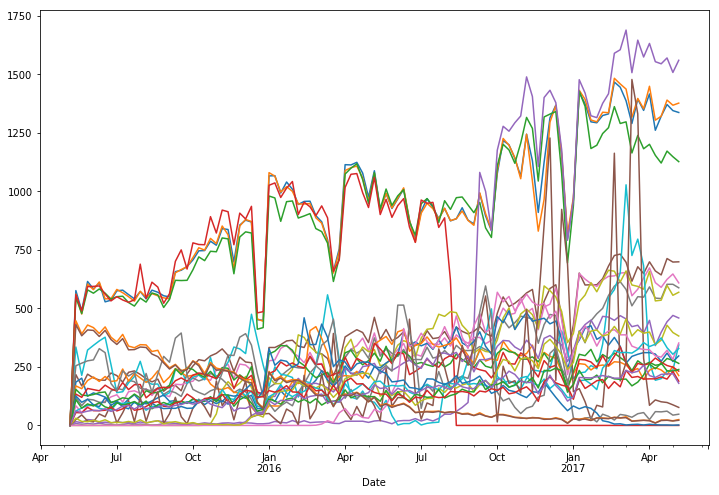

In [62]:
for i in range(1, 27):
    # Create a line plot
    all_years[all_years.part_num == i].part_count.plot(figsize=(12, 8));

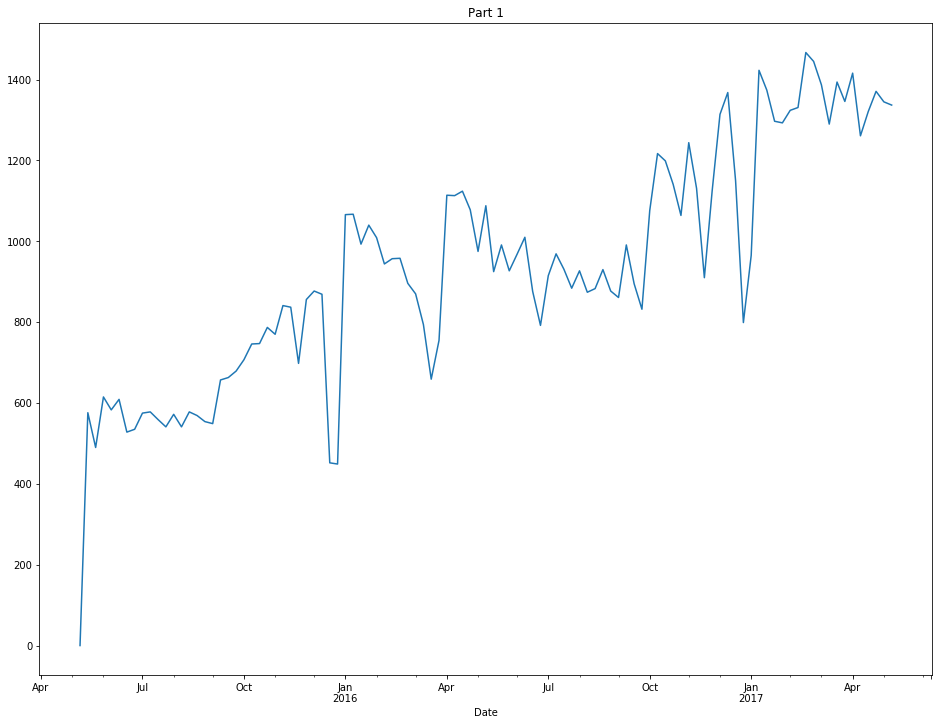

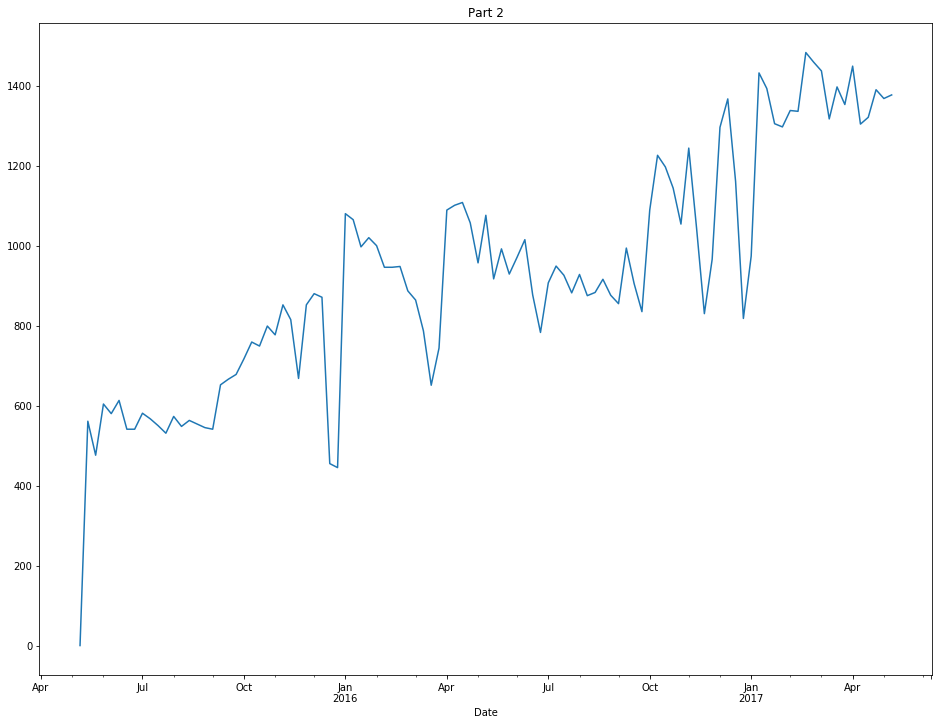

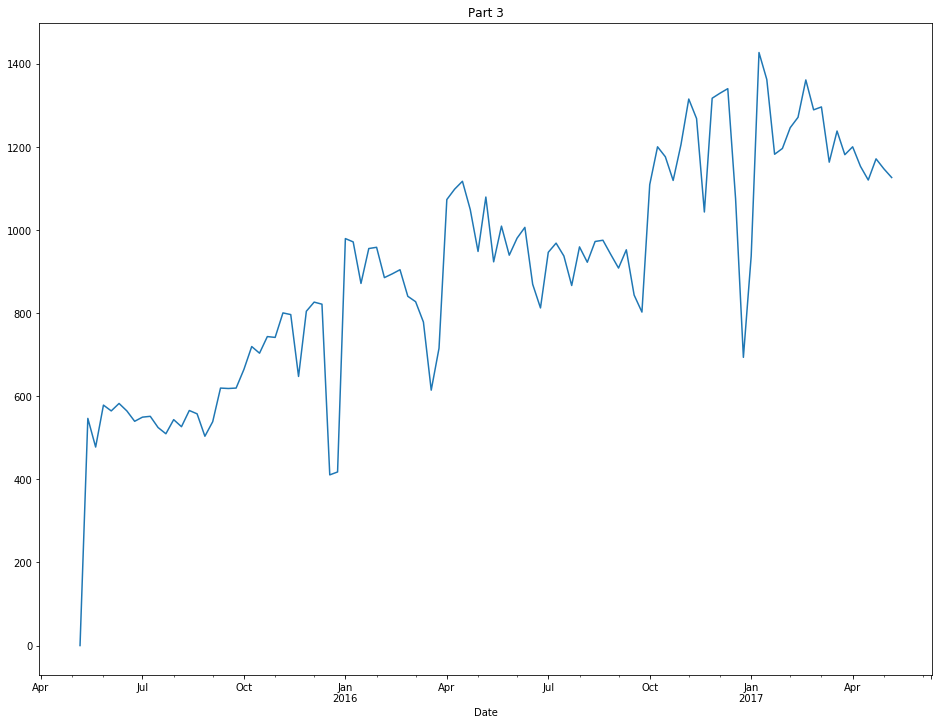

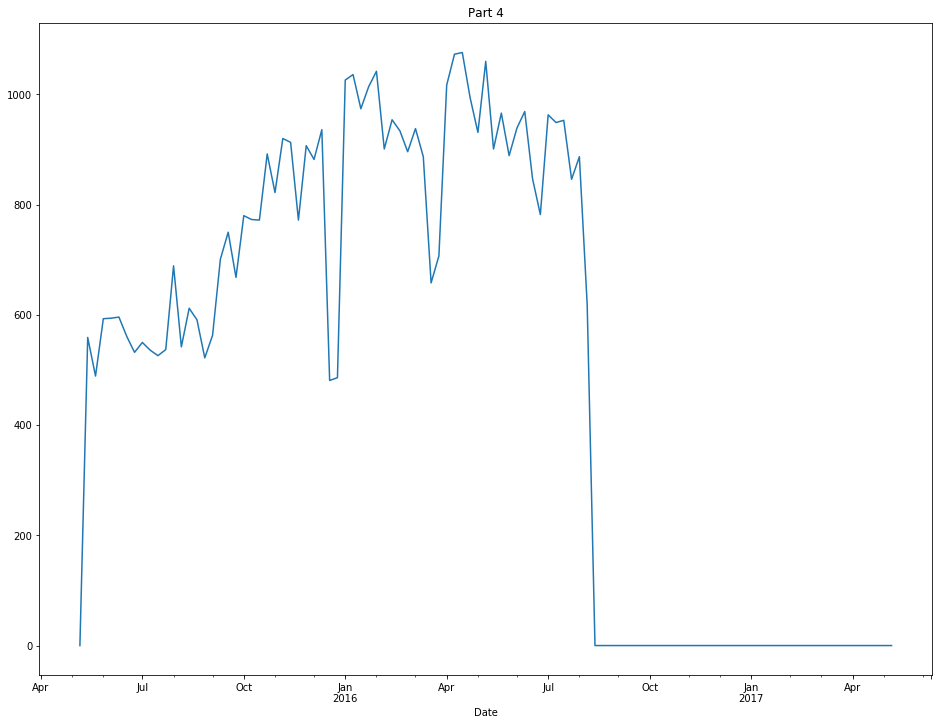

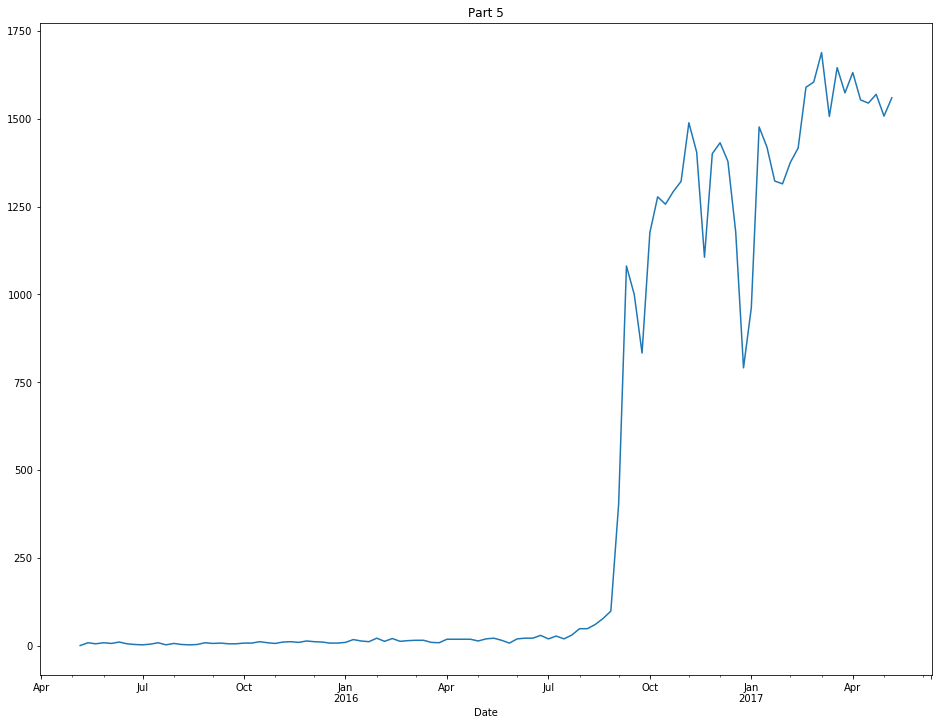

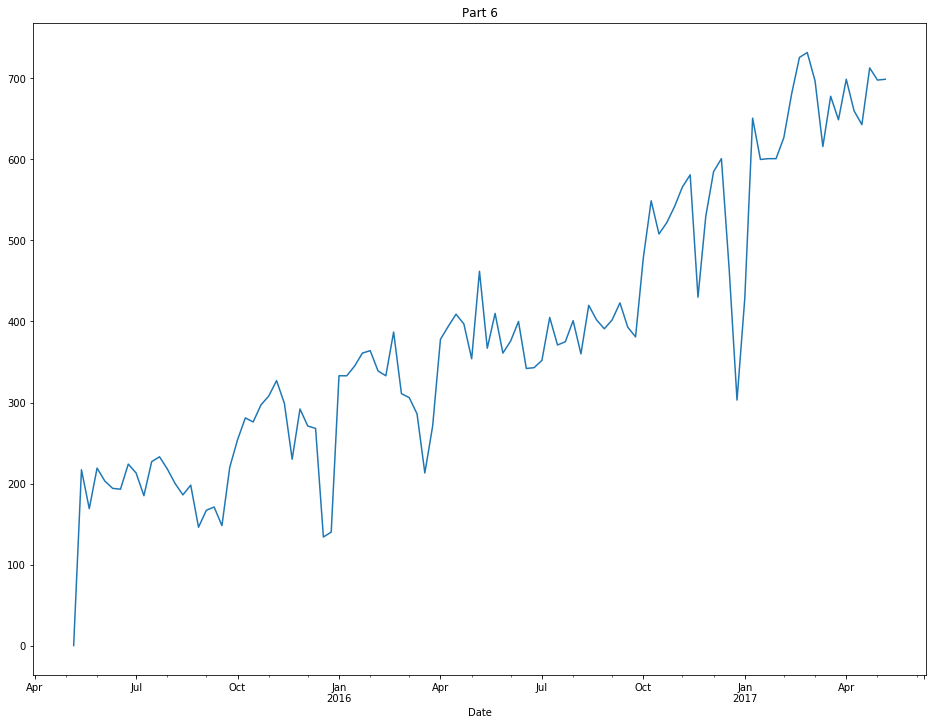

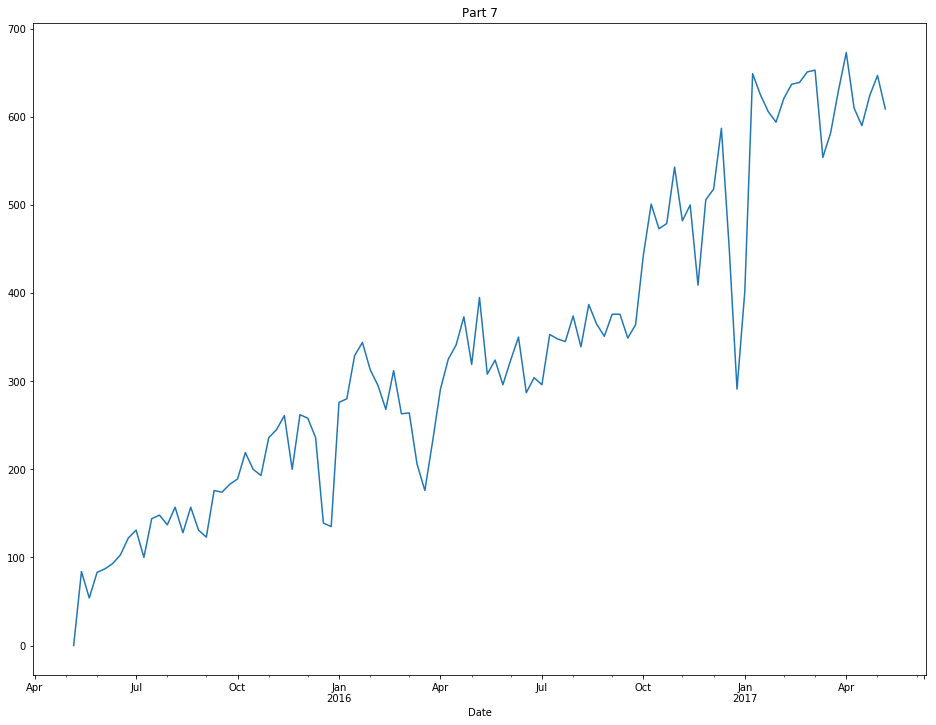

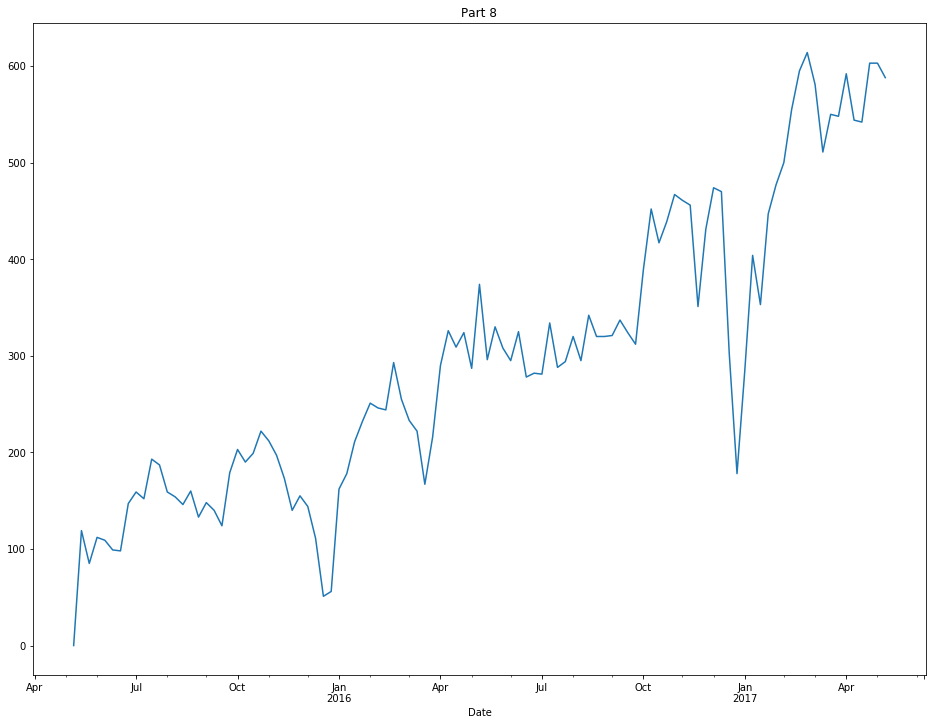

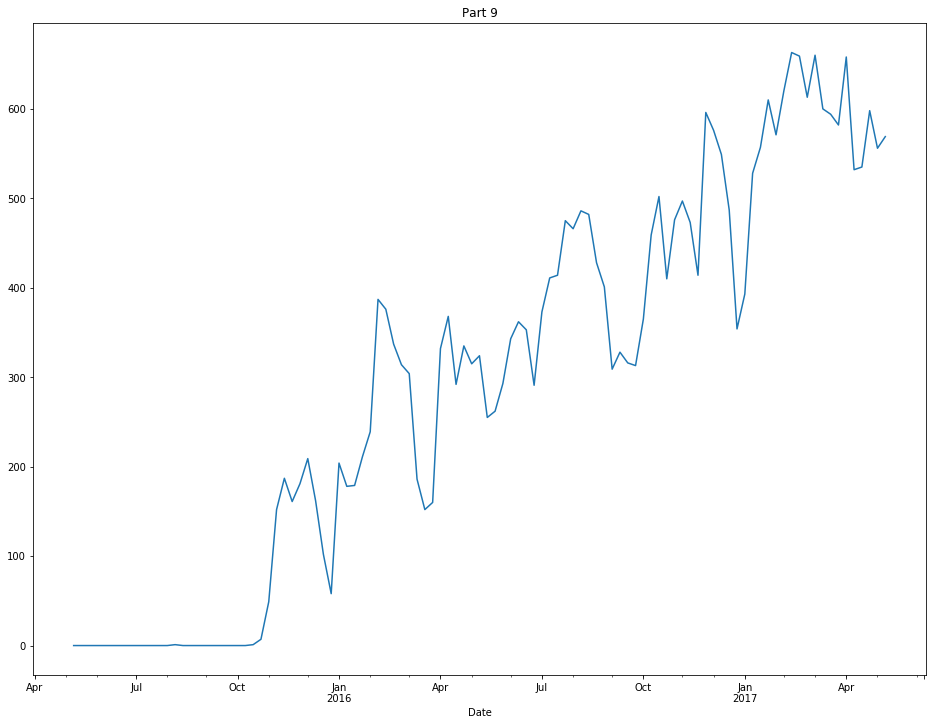

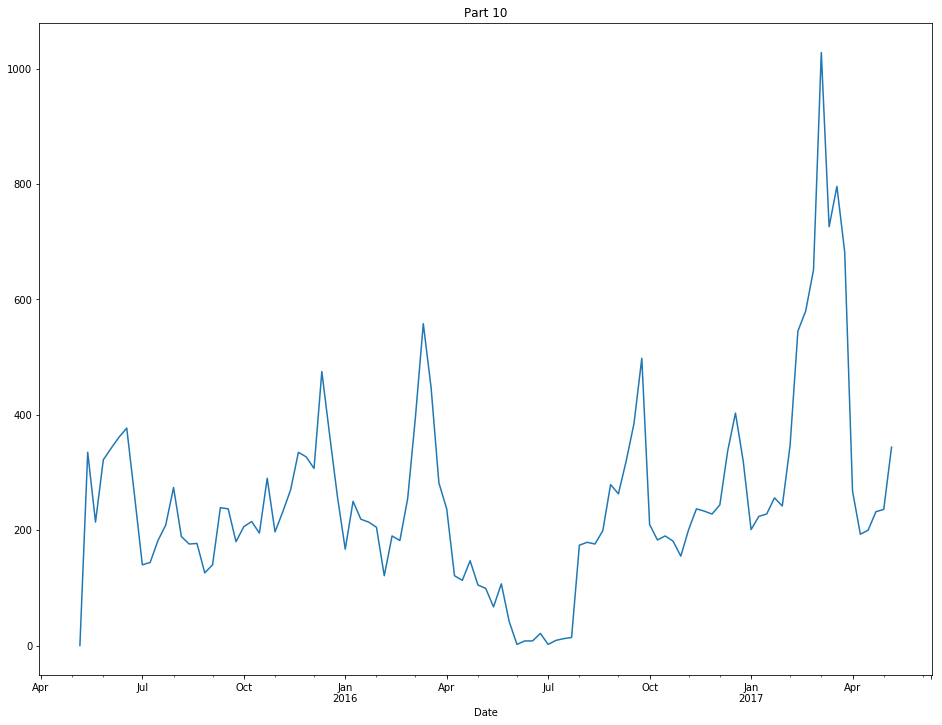

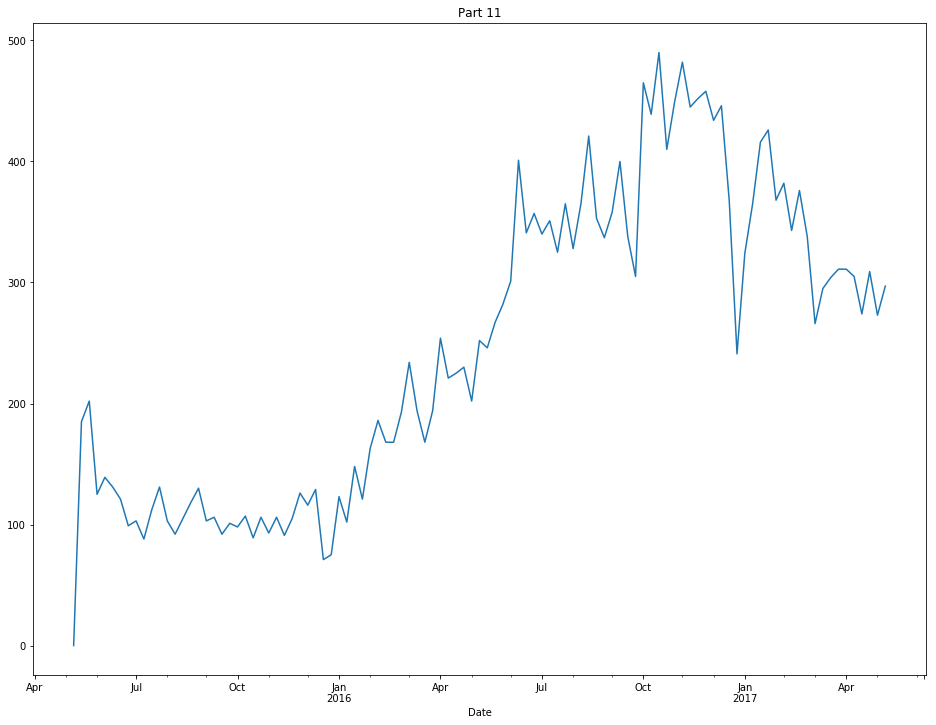

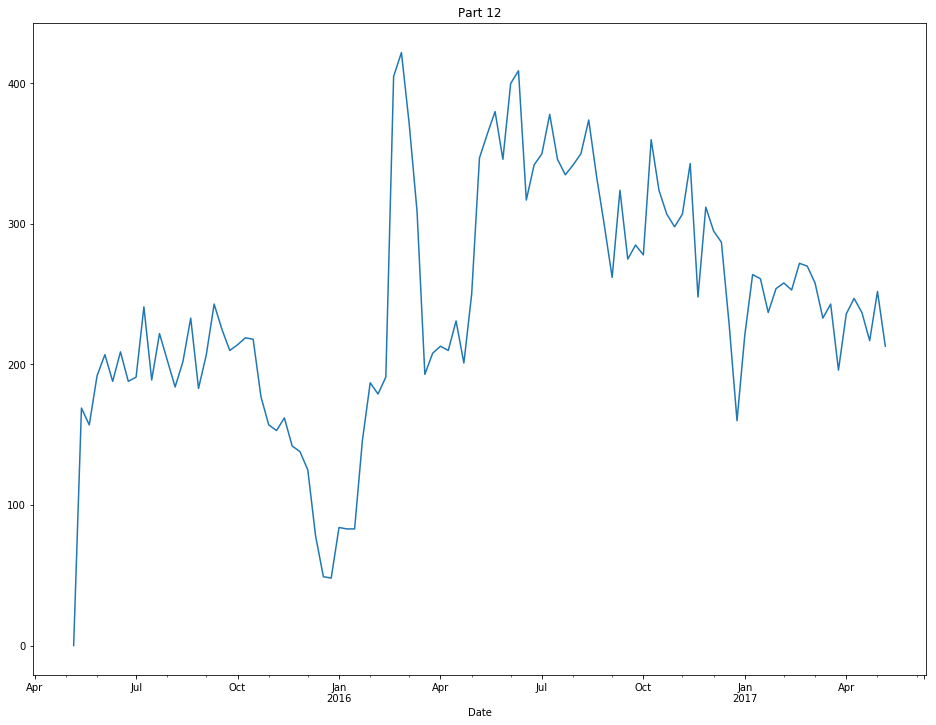

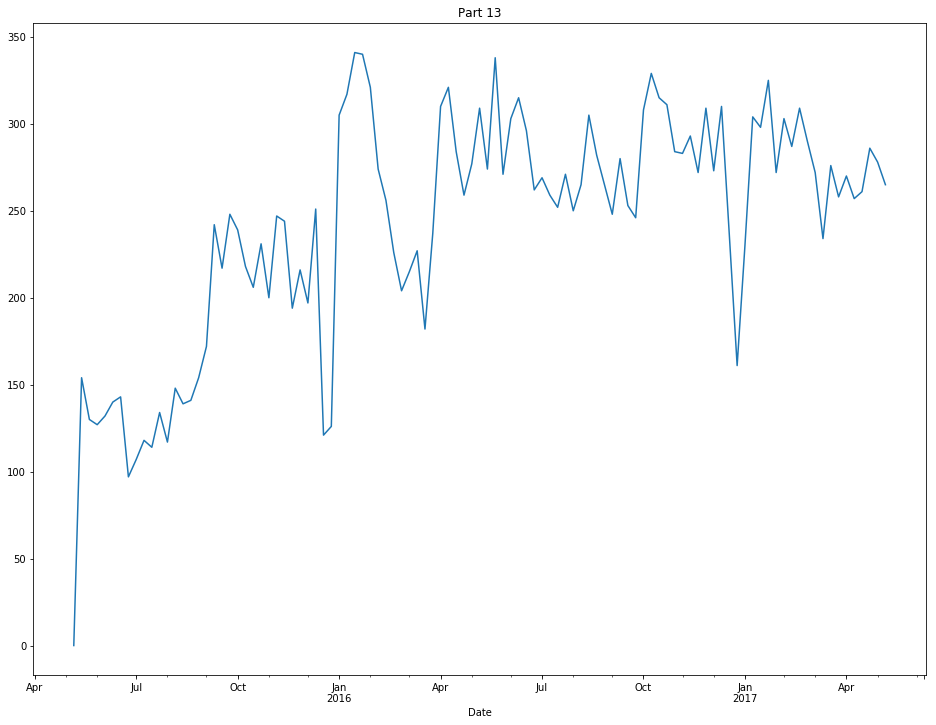

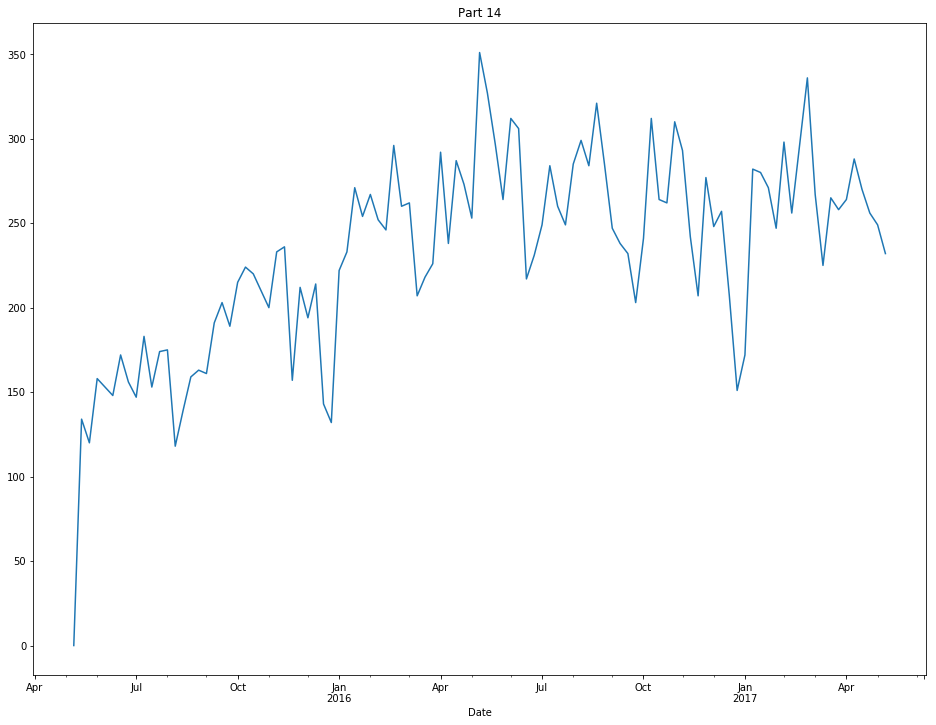

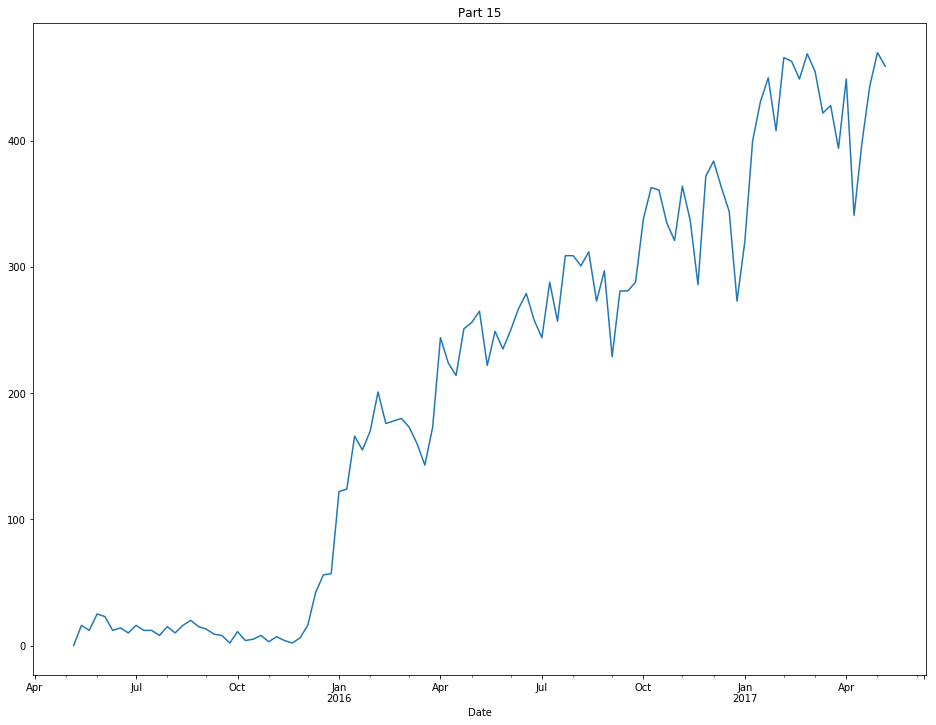

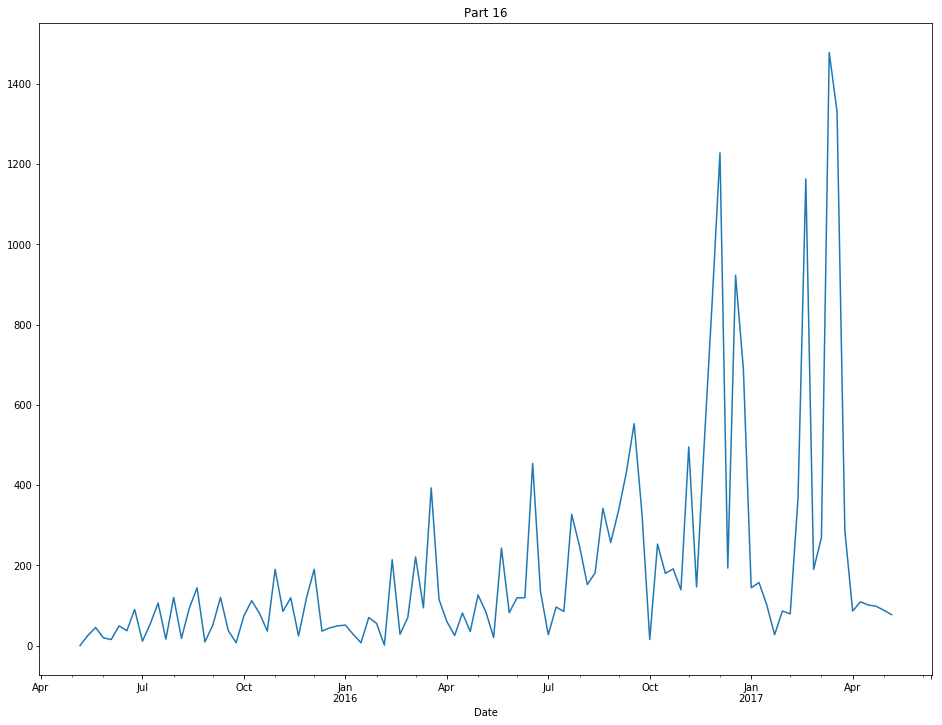

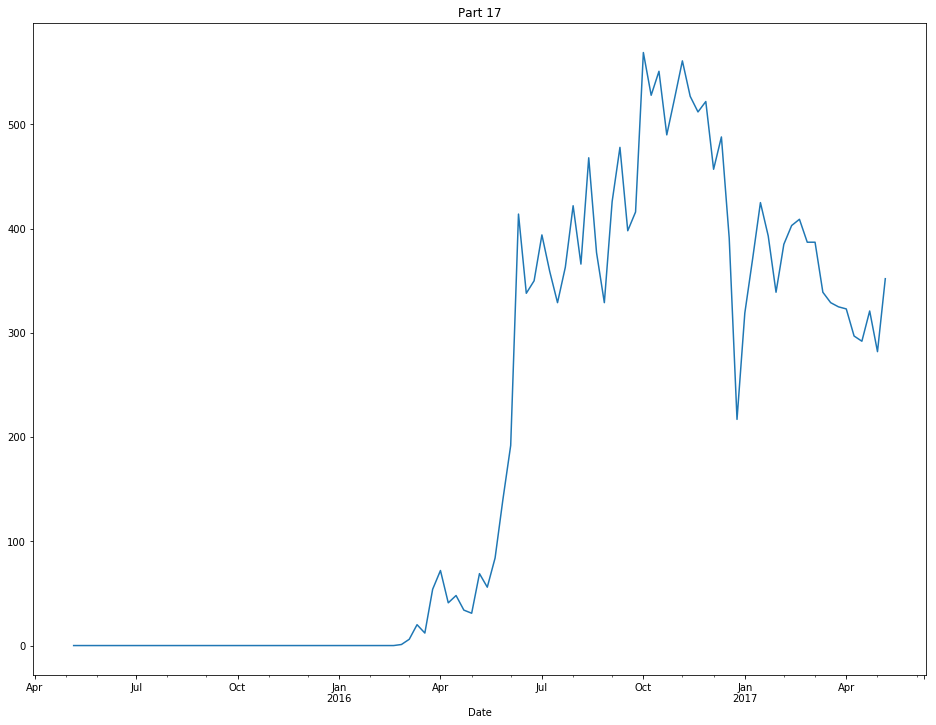

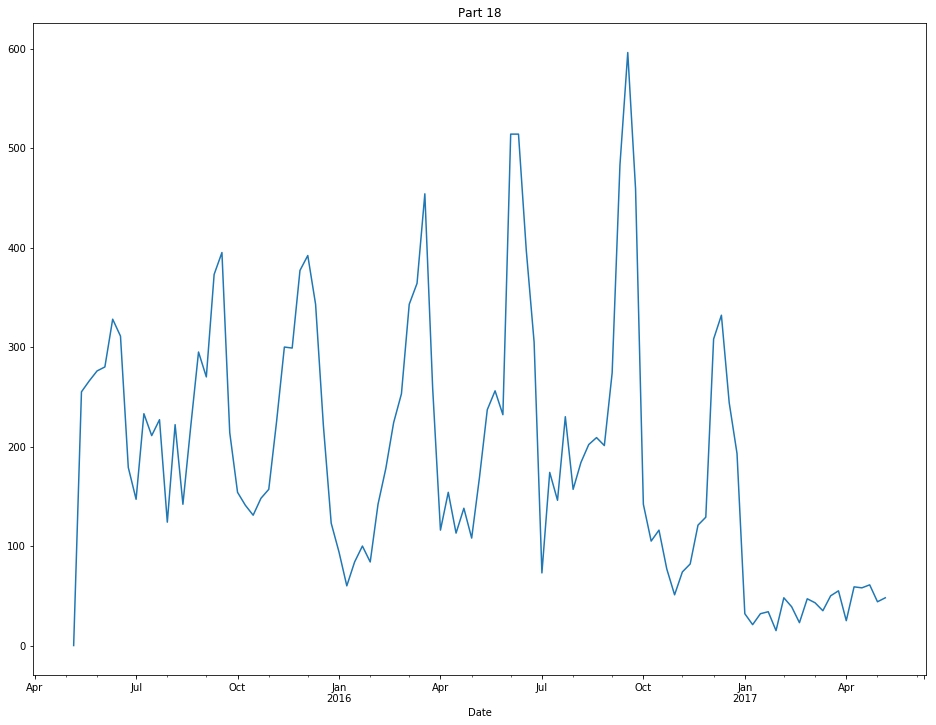

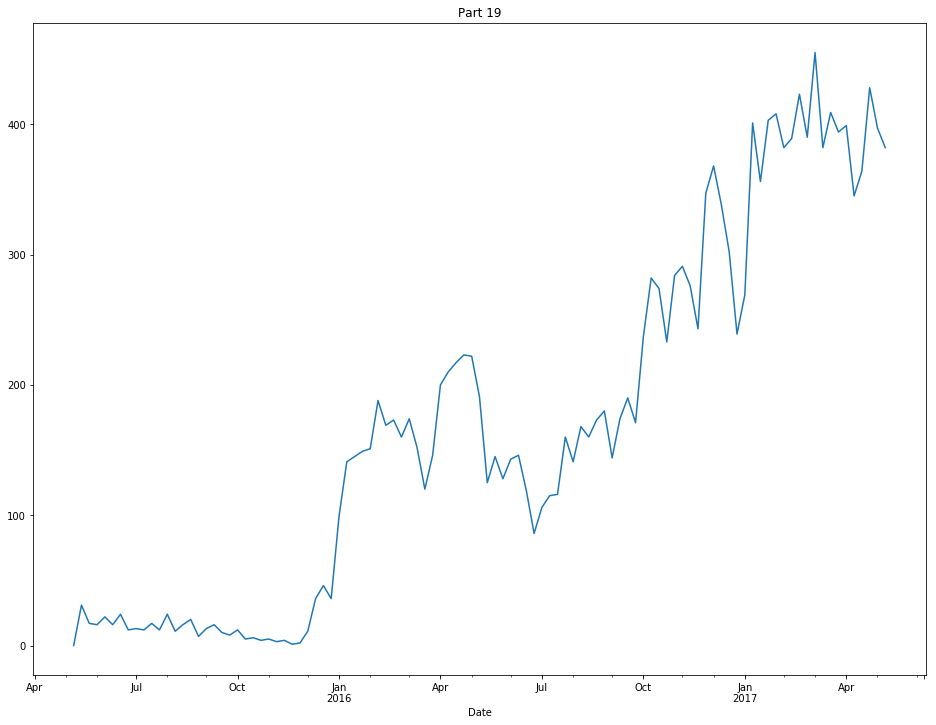

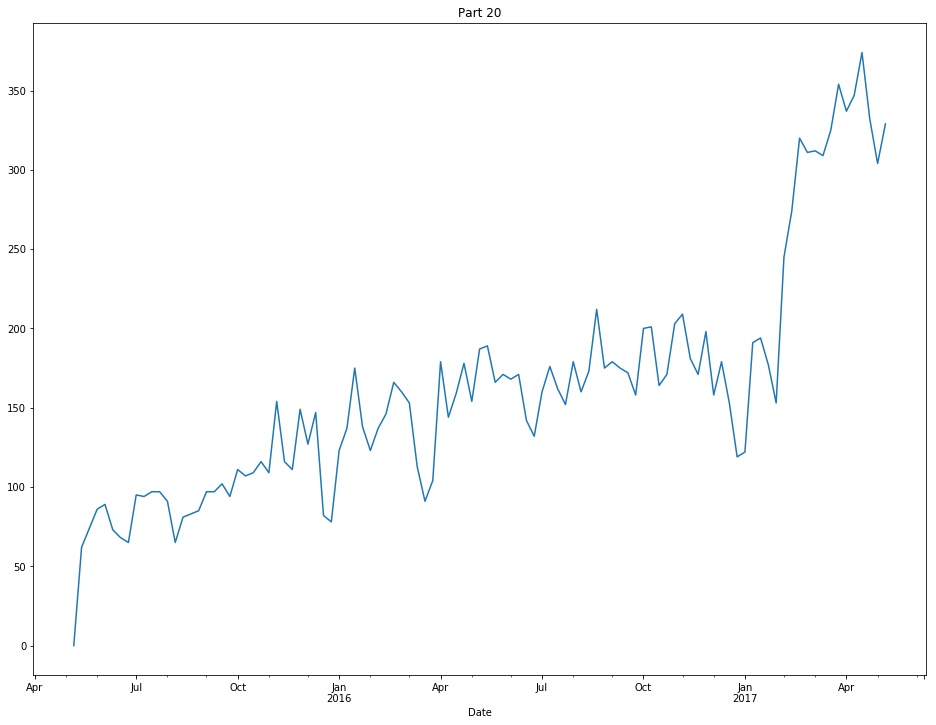

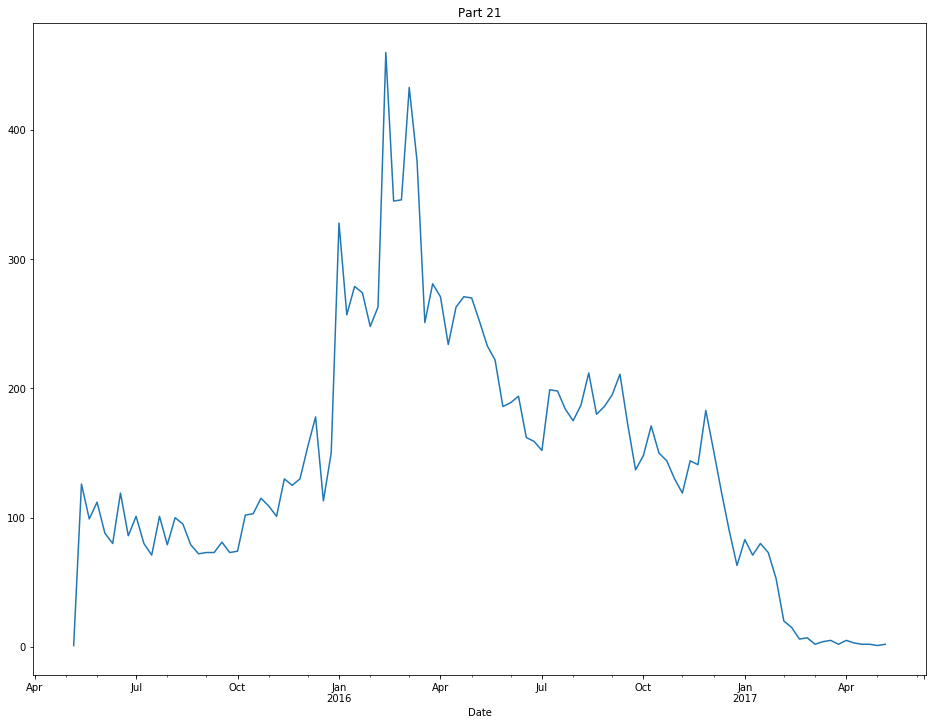

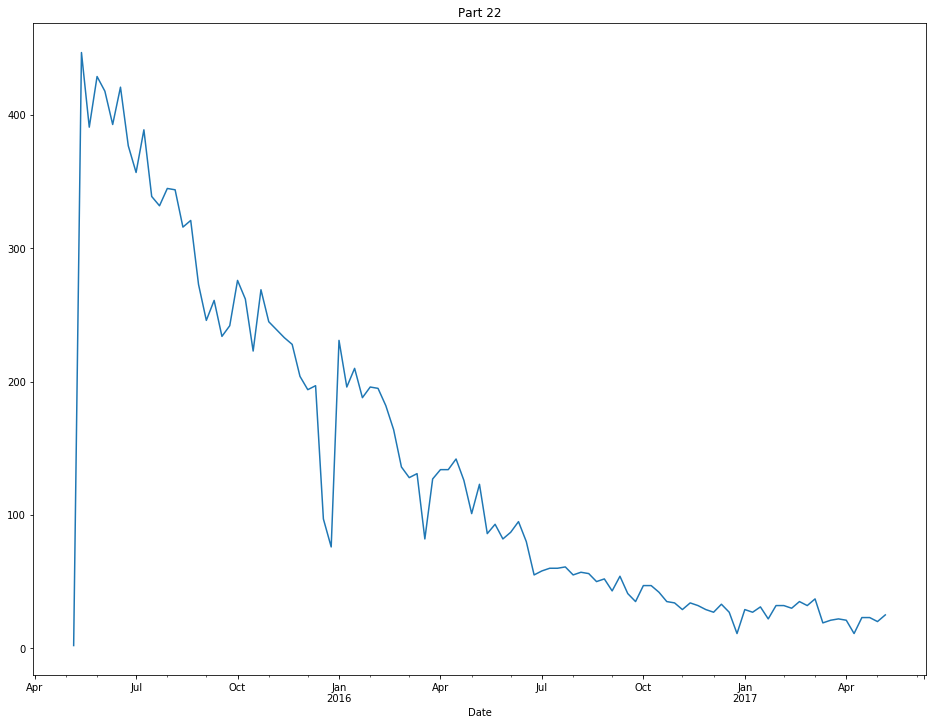

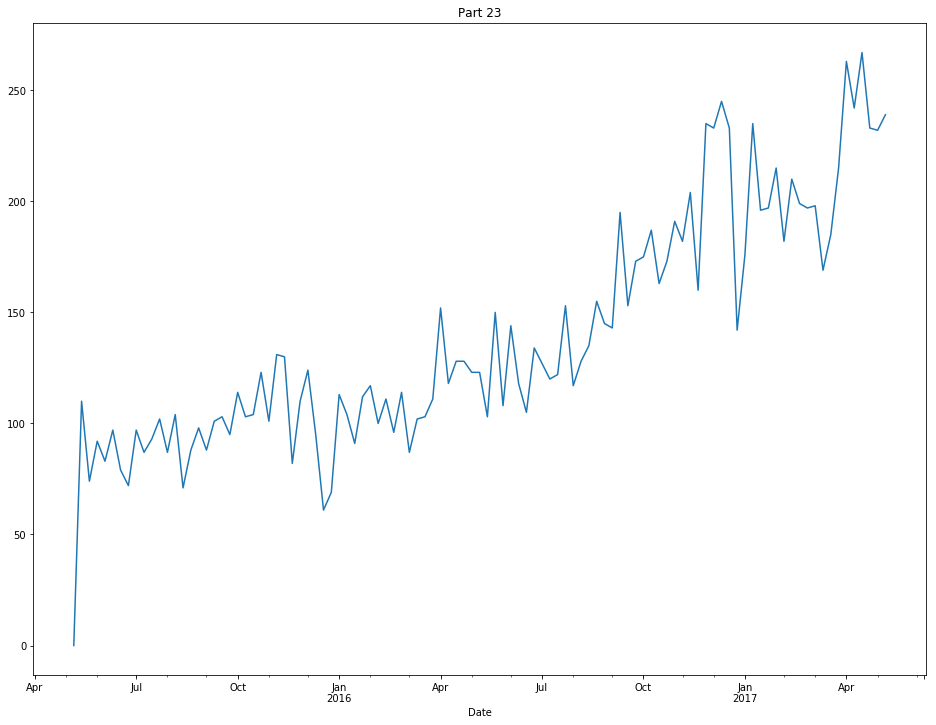

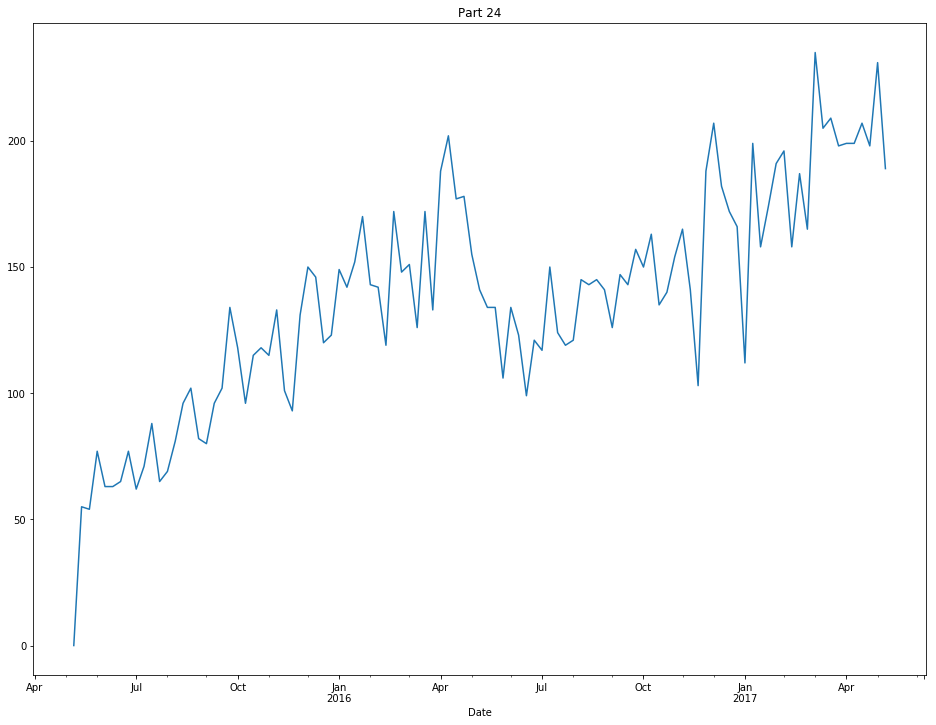

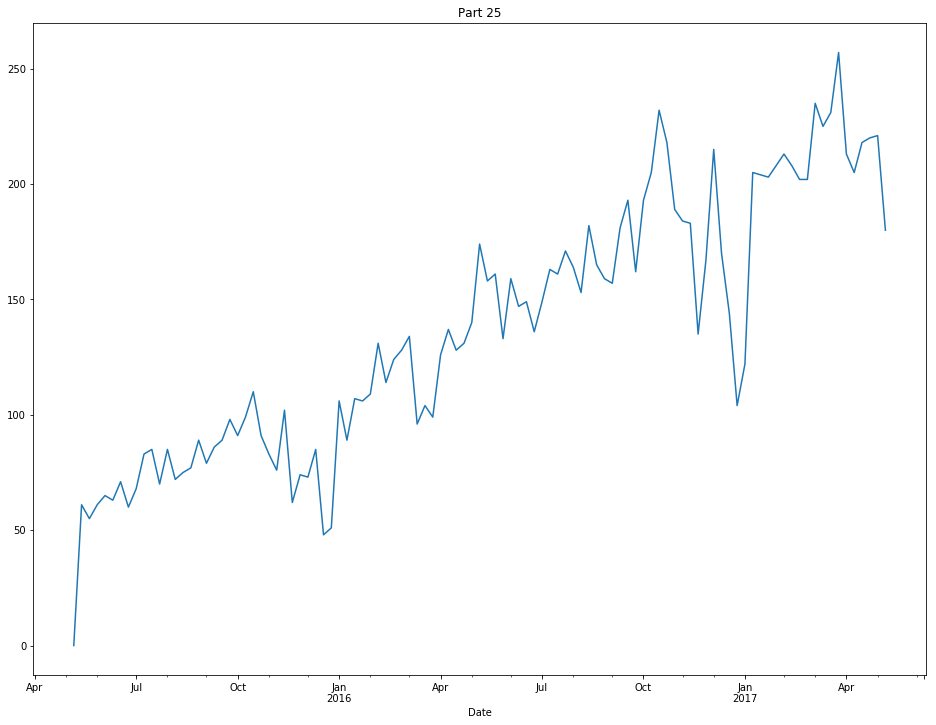

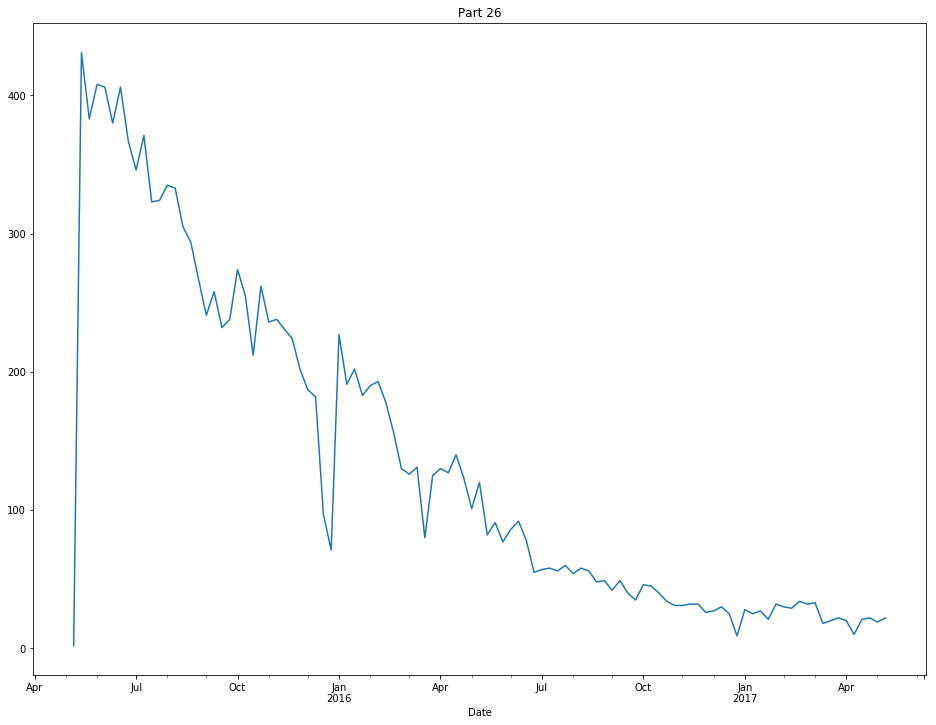

In [63]:
for i in range(1, 27):
    # Create a line plot
    all_years[all_years.part_num == i].part_count.plot(title='Part {}'.format(i), figsize=(16, 12));
    plt.show()

# Time Series Forecasting Methods

In [64]:
# Print a concise summary of a DataFrame including the index dtype and column dtypes, non-null values, and memory usage
# Note: Useful to quickly see if null values exist 
all_years.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2730 entries, 2015-05-11 to 2017-05-08
Data columns (total 4 columns):
year          2730 non-null int64
week          2730 non-null int64
part_num      2730 non-null int64
part_count    2730 non-null int64
dtypes: int64(4)
memory usage: 186.6 KB


In [65]:
# Print the first 5 rows of the DataFrame
all_years.head()

,year,week,part_num,part_count
Date,,,,
2015-05-11,2015,19,1,0
2015-05-11,2015,19,2,0
2015-05-11,2015,19,3,0
2015-05-11,2015,19,4,0
2015-05-11,2015,19,5,0


In [66]:
# Convert categorical variable into dummy/indicator variables
# Note: prefix: string to append DataFrame column names
week_dummies = pd.get_dummies(all_years.week, prefix='week')
#week_dummies.head()

In [67]:
# Remove a column on the original DataFrame rather than returning a new view
# Note: axis=0 for rows, 1 for columns
#       inplace=True changes the original DataFrame
week_dummies.drop(week_dummies.columns[0], axis=1, inplace=True)

In [68]:
# Convert categorical variable into dummy/indicator variables
# Note: prefix: string to append DataFrame column names
part_num_dummies = pd.get_dummies(all_years.part_num, prefix='part_num')
#part_num_dummies.head()

In [69]:
# Remove a column on the original DataFrame rather than returning a new view
# Note: axis=0 for rows, 1 for columns
#       inplace=True changes the original DataFrame
part_num_dummies.drop(part_num_dummies.columns[0], axis=1, inplace=True)

In [70]:
# Concatenate three DataFrames
# Note: axis=0 for rows, axis=1 for columns
all_years_dummies = pd.concat([all_years, week_dummies, part_num_dummies], axis=1)
#all_years_dummies.head()

In [71]:
# Column labels to use for resulting frame
all_years_dummies.columns

Index(['year', 'week', 'part_num', 'part_count', 'week_2', 'week_3', 'week_4',
       'week_5', 'week_6', 'week_7', 'week_8', 'week_9', 'week_10', 'week_11',
       'week_12', 'week_13', 'week_14', 'week_15', 'week_16', 'week_17',
       'week_18', 'week_19', 'week_20', 'week_21', 'week_22', 'week_23',
       'week_24', 'week_25', 'week_26', 'week_27', 'week_28', 'week_29',
       'week_30', 'week_31', 'week_32', 'week_33', 'week_34', 'week_35',
       'week_36', 'week_37', 'week_38', 'week_39', 'week_40', 'week_41',
       'week_42', 'week_43', 'week_44', 'week_45', 'week_46', 'week_47',
       'week_48', 'week_49', 'week_50', 'week_51', 'week_52', 'part_num_2',
       'part_num_3', 'part_num_4', 'part_num_5', 'part_num_6', 'part_num_7',
       'part_num_8', 'part_num_9', 'part_num_10', 'part_num_11', 'part_num_12',
       'part_num_13', 'part_num_14', 'part_num_15', 'part_num_16',
       'part_num_17', 'part_num_18', 'part_num_19', 'part_num_20',
       'part_num_21', 'part_num_22', 

#### Predicting Part Count

In [72]:
# Create a list of features
feature_cols = ['week_2', 'week_3', 'week_4', 'week_5', 'week_6', 'week_7', 'week_8', 'week_9', 'week_10', 'week_11',
                'week_12', 'week_13', 'week_14', 'week_15', 'week_16', 'week_17', 'week_18', 'week_19', 'week_20',
                'week_21', 'week_22', 'week_23', 'week_24', 'week_25', 'week_26', 'week_27', 'week_28', 'week_29',
                'week_30', 'week_31', 'week_32', 'week_33', 'week_34', 'week_35', 'week_36', 'week_37', 'week_38',
                'week_39', 'week_40', 'week_41', 'week_42', 'week_43', 'week_44', 'week_45', 'week_46', 'week_47',
                'week_48', 'week_49', 'week_50', 'week_51', 'week_52', 'part_num_2', 'part_num_3', 'part_num_4',
                'part_num_5', 'part_num_6', 'part_num_7', 'part_num_8', 'part_num_9', 'part_num_10', 'part_num_11',
                'part_num_12', 'part_num_13', 'part_num_14', 'part_num_15', 'part_num_16', 'part_num_17',
                'part_num_18', 'part_num_19', 'part_num_20', 'part_num_21', 'part_num_22', 'part_num_23',
                'part_num_24', 'part_num_25', 'part_num_26']

In [73]:
# Create X and y
X = all_years_dummies[feature_cols]
y = all_years_dummies.part_count

In [74]:
# Change the maximum number of rows and columns printed
# Note: 'None' value means unlimited
pd.set_option('max_rows', None)     # default: 60 rows
pd.set_option('max_columns', None)  # default: 20 columns

#### 70/30 train-test-split

In [75]:
# Split X and y into training and testing sets
# Note: train_size: between 0.0 and 1.0 and represent the proportion of the dataset to include in the train split
#       test_size: between 0.0 and 1.0 and represent the proportion of the dataset to include in the test split
#       random_state: the seed used by the random number generator
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.70, test_size=0.30, random_state=65)

#### Compute Baseline (Null) RMSE
https://machinelearningmastery.com/how-to-get-baseline-results-and-why-they-matter/

Note: Using a null model (i.e., using the mean value for the prediction). <br>

Null RMSE is the RMSE that could be achieved by always predicting the mean response value. It is a benchmark against which you may want to measure your regression model.

In [76]:
# Create a NumPy array with the same shape as y_test
y_null = np.zeros_like(y_test, dtype=float)

# Fill the array with the mean value of y_test
y_null.fill(y_test.mean())
y_null[0]

313.83150183150184

In [77]:
# Mean squared error (MSE) regression loss
print('Baseline (Null) MSE:', round(metrics.mean_squared_error(y_test, y_null), 3))

# Root mean squared error (RMSE) regression loss
print('Baseline (Null) RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, y_null)), 3))

Baseline (Null) MSE: 102227.439
Baseline (Null) RMSE: 319.73


In [78]:
# Instantiate an ordinary least squares LinearRegression model and fit linear model
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# Print the intercept and coefficient(s)
print('Intercept:', round(linreg.intercept_, 4))
print('Coefficient(s):', list(zip(feature_cols, np.round(linreg.coef_, 4))))

Intercept: 963.8788
Coefficient(s): [('week_2', 80.6569), ('week_3', 63.4977), ('week_4', 83.0355), ('week_5', 75.9506), ('week_6', 103.3063), ('week_7', 108.965), ('week_8', 194.0997), ('week_9', 136.2741), ('week_10', 119.4202), ('week_11', 98.7636), ('week_12', 81.873), ('week_13', 61.154), ('week_14', 115.6297), ('week_15', 93.2451), ('week_16', 91.0355), ('week_17', 120.2803), ('week_18', 75.9704), ('week_19', -9.8075), ('week_20', -12.3421), ('week_21', -29.9465), ('week_22', -33.0318), ('week_23', 11.6497), ('week_24', -20.3296), ('week_25', -57.0846), ('week_26', -53.5758), ('week_27', -64.5246), ('week_28', -47.3416), ('week_29', -74.6589), ('week_30', -28.8061), ('week_31', -8.6635), ('week_32', -25.9997), ('week_33', -47.4406), ('week_34', -33.4956), ('week_35', -27.555), ('week_36', -29.3077), ('week_37', -7.8765), ('week_38', -14.506), ('week_39', -52.6343), ('week_40', 9.8961), ('week_41', 39.758), ('week_42', 24.207), ('week_43', 23.8991), ('week_44', 27.6755), ('week_45

In [79]:
name = X.columns
coef = np.round(linreg.coef_, 4)
pd.DataFrame([name, coef], index=['Name', 'Coefficient']).transpose()

,Name,Coefficient
0,week_2,80.6569
1,week_3,63.4977
2,week_4,83.0355
3,week_5,75.9506
4,week_6,103.306
5,week_7,108.965
6,week_8,194.1
7,week_9,136.274
8,week_10,119.42
9,week_11,98.7636


In [80]:
# Returns the coefficient of determination R^2 of the prediction
print('R^2:', round(linreg.score(X_test, y_test), 3))

R^2: 0.517


In [81]:
# Predict using the linear model
y_pred = linreg.predict(X_test)

In [82]:
# Mean squared error (MSE) regression loss
print('Training MSE:', round(metrics.mean_squared_error(y_train, linreg.predict(X_train)), 3))

# Root mean squared error (RMSE) regression loss
print('Training RMSE:', round(np.sqrt(metrics.mean_squared_error(y_train, linreg.predict(X_train))), 3))
print('')

# Mean squared error (MSE) regression loss
print('Testing MSE:', round(metrics.mean_squared_error(y_test, y_pred), 3))

# Root mean squared error (RMSE) regression loss
print('Testing RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)), 3))
print('')

if sqrt(metrics.mean_squared_error(y_train, linreg.predict(X_train))) < sqrt(metrics.mean_squared_error(y_test, y_pred)):
    print('Testing RMSE > Training RMSE')
    print('-> Overfitting!')
else:
    print('Testing RMSE < Training RMSE')
    print('-> Not overfitting')

Training MSE: 43299.276
Training RMSE: 208.085

Testing MSE: 49412.455
Testing RMSE: 222.289

Testing RMSE > Training RMSE
-> Overfitting!


#### 80/20 train-test-split

In [83]:
# Split X and y into training and testing sets
# Note: train_size: between 0.0 and 1.0 and represent the proportion of the dataset to include in the train split
#       test_size: between 0.0 and 1.0 and represent the proportion of the dataset to include in the test split
#       random_state: the seed used by the random number generator
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, test_size=0.20, random_state=65)

#### Compute Baseline (Null) RMSE
https://machinelearningmastery.com/how-to-get-baseline-results-and-why-they-matter/

Note: Using a null model (i.e., using the mean value for the prediction). <br>

Null RMSE is the RMSE that could be achieved by always predicting the mean response value. It is a benchmark against which you may want to measure your regression model.

In [84]:
# Create a NumPy array with the same shape as y_test
y_null = np.zeros_like(y_test, dtype=float)

# Fill the array with the mean value of y_test
y_null.fill(y_test.mean())
y_null[0]

327.32783882783883

In [85]:
# Mean squared error (MSE) regression loss
print('Baseline (Null) MSE:', round(metrics.mean_squared_error(y_test, y_null), 3))

# Root mean squared error (RMSE) regression loss
print('Baseline (Null) RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, y_null)), 3))

Baseline (Null) MSE: 107237.316
Baseline (Null) RMSE: 327.471


In [86]:
# Instantiate an ordinary least squares LinearRegression model and fit linear model
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# Print the intercept and coefficient(s)
print('Intercept:', round(linreg.intercept_, 4))
print('Coefficient(s):', list(zip(feature_cols, np.round(linreg.coef_, 4))))

Intercept: 942.644
Coefficient(s): [('week_2', 60.0213), ('week_3', 56.7816), ('week_4', 70.9873), ('week_5', 69.1158), ('week_6', 52.6466), ('week_7', 104.0901), ('week_8', 156.555), ('week_9', 101.8319), ('week_10', 91.2301), ('week_11', 96.2503), ('week_12', 79.0716), ('week_13', 53.834), ('week_14', 99.5789), ('week_15', 83.8351), ('week_16', 84.2303), ('week_17', 103.8459), ('week_18', 76.5235), ('week_19', -33.4567), ('week_20', -23.5658), ('week_21', -35.7837), ('week_22', -49.4746), ('week_23', -18.1086), ('week_24', -20.5422), ('week_25', -64.5396), ('week_26', -69.8331), ('week_27', -50.5478), ('week_28', -59.5806), ('week_29', -53.9185), ('week_30', -40.7298), ('week_31', -27.1044), ('week_32', -33.8716), ('week_33', -49.3046), ('week_34', -33.6066), ('week_35', -36.804), ('week_36', -38.2025), ('week_37', -2.0392), ('week_38', -16.5054), ('week_39', -51.3789), ('week_40', 8.8119), ('week_41', 23.8828), ('week_42', 19.5856), ('week_43', 9.8584), ('week_44', 6.5519), ('week_4

In [87]:
name = X.columns
coef = np.round(linreg.coef_, 4)
pd.DataFrame([name, coef], index=['Name', 'Coefficient']).transpose()

,Name,Coefficient
0,week_2,60.0213
1,week_3,56.7816
2,week_4,70.9873
3,week_5,69.1158
4,week_6,52.6466
5,week_7,104.09
6,week_8,156.555
7,week_9,101.832
8,week_10,91.2301
9,week_11,96.2503


In [88]:
# Returns the coefficient of determination R^2 of the prediction
print('R^2:', round(linreg.score(X_test, y_test), 3))

R^2: 0.514


In [89]:
# Predict using the linear model
y_pred = linreg.predict(X_test)

In [90]:
# Mean squared error (MSE) regression loss
print('Training MSE:', round(metrics.mean_squared_error(y_train, linreg.predict(X_train)), 3))

# Root mean squared error (RMSE) regression loss
print('Training RMSE:', round(np.sqrt(metrics.mean_squared_error(y_train, linreg.predict(X_train))), 3))
print('')

# Mean squared error (MSE) regression loss
print('Testing MSE:', round(metrics.mean_squared_error(y_test, y_pred), 3))

# Root mean squared error (RMSE) regression loss
print('Testing RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)), 3))
print('')

if sqrt(metrics.mean_squared_error(y_train, linreg.predict(X_train))) < sqrt(metrics.mean_squared_error(y_test, y_pred)):
    print('Testing RMSE > Training RMSE')
    print('-> Overfitting!')
else:
    print('Testing RMSE < Training RMSE')
    print('-> Not overfitting')

Training MSE: 43031.544
Training RMSE: 207.44

Testing MSE: 52136.167
Testing RMSE: 228.333

Testing RMSE > Training RMSE
-> Overfitting!


#### 90/10 train-test-split

In [91]:
# Split X and y into training and testing sets
# Note: train_size: between 0.0 and 1.0 and represent the proportion of the dataset to include in the train split
#       test_size: between 0.0 and 1.0 and represent the proportion of the dataset to include in the test split
#       random_state: the seed used by the random number generator
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.90, test_size=0.10, random_state=65)

#### Compute Baseline (Null) RMSE
https://machinelearningmastery.com/how-to-get-baseline-results-and-why-they-matter/

Note: Using a null model (i.e., using the mean value for the prediction). <br>

Null RMSE is the RMSE that could be achieved by always predicting the mean response value. It is a benchmark against which you may want to measure your regression model.

In [92]:
# Create a NumPy array with the same shape as y_test
y_null = np.zeros_like(y_test, dtype=float)

# Fill the array with the mean value of y_test
y_null.fill(y_test.mean())
y_null[0]

319.989010989011

In [93]:
# Mean squared error (MSE) regression loss
print('Baseline (Null) MSE:', round(metrics.mean_squared_error(y_test, y_null), 3))

# Root mean squared error (RMSE) regression loss
print('Baseline (Null) RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, y_null)), 3))

Baseline (Null) MSE: 89638.956
Baseline (Null) RMSE: 299.398


In [94]:
# Instantiate an ordinary least squares LinearRegression model and fit linear model
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# Print the intercept and coefficient(s)
print('Intercept:', round(linreg.intercept_, 4))
print('Coefficient(s):', list(zip(feature_cols, np.round(linreg.coef_, 4))))

Intercept: 931.8851
Coefficient(s): [('week_2', 61.2034), ('week_3', 45.9494), ('week_4', 59.9714), ('week_5', 72.6367), ('week_6', 67.8455), ('week_7', 90.6907), ('week_8', 148.8221), ('week_9', 98.0415), ('week_10', 118.7031), ('week_11', 96.8643), ('week_12', 90.3093), ('week_13', 64.0065), ('week_14', 108.9533), ('week_15', 85.215), ('week_16', 86.581), ('week_17', 100.1596), ('week_18', 78.2958), ('week_19', -32.3678), ('week_20', -24.385), ('week_21', -34.5676), ('week_22', -50.9045), ('week_23', -35.0074), ('week_24', -23.1631), ('week_25', -45.892), ('week_26', -61.4397), ('week_27', -50.5321), ('week_28', -46.714), ('week_29', -49.3116), ('week_30', -35.5714), ('week_31', -39.424), ('week_32', -52.3882), ('week_33', -46.0981), ('week_34', -38.8473), ('week_35', -50.6292), ('week_36', -47.4275), ('week_37', 0.4835), ('week_38', -15.4275), ('week_39', -35.8292), ('week_40', 5.9872), ('week_41', 32.6612), ('week_42', 30.5611), ('week_43', 27.2862), ('week_44', 5.8974), ('week_45'

In [95]:
name = X.columns
coef = np.round(linreg.coef_, 4)
pd.DataFrame([name, coef], index=['Name', 'Coefficient']).transpose()

,Name,Coefficient
0,week_2,61.2034
1,week_3,45.9494
2,week_4,59.9714
3,week_5,72.6367
4,week_6,67.8455
5,week_7,90.6907
6,week_8,148.822
7,week_9,98.0415
8,week_10,118.703
9,week_11,96.8643


In [96]:
# Returns the coefficient of determination R^2 of the prediction
print('R^2:', round(linreg.score(X_test, y_test), 3))

R^2: 0.484


In [97]:
# Predict using the linear model
y_pred = linreg.predict(X_test)

In [98]:
# Mean squared error (MSE) regression loss
print('Training MSE:', round(metrics.mean_squared_error(y_train, linreg.predict(X_train)), 3))

# Root mean squared error (RMSE) regression loss
print('Training RMSE:', round(np.sqrt(metrics.mean_squared_error(y_train, linreg.predict(X_train))), 3))
print('')

# Mean squared error (MSE) regression loss
print('Testing MSE:', round(metrics.mean_squared_error(y_test, y_pred), 3))

# Root mean squared error (RMSE) regression loss
print('Testing RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)), 3))
print('')

if sqrt(metrics.mean_squared_error(y_train, linreg.predict(X_train))) < sqrt(metrics.mean_squared_error(y_test, y_pred)):
    print('Testing RMSE > Training RMSE')
    print('-> Overfitting!')
else:
    print('Testing RMSE < Training RMSE')
    print('-> Not overfitting')

Training MSE: 44549.949
Training RMSE: 211.069

Testing MSE: 46282.947
Testing RMSE: 215.135

Testing RMSE > Training RMSE
-> Overfitting!


In [99]:
# Reset the number of rows and columns printed to defaults
pd.reset_option('max_rows')
pd.reset_option('max_columns')